In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr, pearsonr, ranksums, linregress
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
import itertools
import statannot
from statsmodels.stats.multitest import fdrcorrection

from deeplift.visualization import viz_sequence


matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'


# HEPG2_COL = 'log2FoldChange_HepG2_DNA'
# K562_COL = 'log2FoldChange_K562_DNA'
HEPG2_COL = 'log2FoldChange_HepG2'
K562_COL = 'log2FoldChange_K562'
H2K_COL = 'log2FoldChange_H2K'

figure_dir = 'figures'

TITLE_FSIZE = 12
AXIS_FSIZE = 12
TEXT_FSIZE = 10

greysBig = matplotlib.cm.get_cmap('Greys', 512)
greys_trunc_cm = matplotlib.colors.ListedColormap(greysBig(np.linspace(0.6, 1, 256)))

bluesBig = matplotlib.cm.get_cmap('Blues', 512)
# blues_trunc_cm = matplotlib.colors.ListedColormap(bluesBig(np.linspace(0.15, 0.8, 256)))
blues_trunc_cm = matplotlib.colors.ListedColormap(bluesBig(np.linspace(0.25, 0.8, 256)))

orangesBig = matplotlib.cm.get_cmap('Oranges', 512)
# oranges_trunc_cm = matplotlib.colors.ListedColormap(orangesBig(np.linspace(0.15, 0.8, 256)))
oranges_trunc_cm = matplotlib.colors.ListedColormap(orangesBig(np.linspace(0.25, 0.8, 256)))

from fig_utils import load_ensemble_model, plot_seq_with_motifs, cluster_name_dict

# import logging from matplotlib
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

from matplotlib import rcParams
rcParams['svg.fonttype'] = 'none'

supp_fig_dir = 'figures/supp_figures'

fig3_dir = f'{figure_dir}/fig3'
os.makedirs(fig3_dir,exist_ok=True)

fig4_dir = f'{figure_dir}/fig4'
os.makedirs(fig4_dir,exist_ok=True)

C:\Users\Chris\AppData\Local\Temp\ipykernel_25036\2789704894.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\Chris\AppData\Local\Temp\ipykernel_25036\2789704894.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greysBig = matplotlib.cm.get_cmap('Greys', 512)
C:\Users\Chris\AppData\Local\Temp\ipykernel_25036\2789704894.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and 

In [2]:
### Load D1, D2, and D3 data ###

# reverse complement function
def reverse_complement(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    return ''.join(complement[base] for base in reversed(seq))

bc_deseqs_dir = 'bc_deseq_dfs/weighted'

d2_deseq_df = pd.read_csv(f'{bc_deseqs_dir}/d2_deseq_df.csv')
d3_seq_df = pd.read_csv(f'{bc_deseqs_dir}/d3_seq_df.csv')

d1_deseq_plus_cluster_cnts_df = pd.read_csv(f'{bc_deseqs_dir}/d1_deseq_plus_cluster_cnts_df.csv')
d2_deseq_plus_cluster_cnts_df = pd.read_csv(f'{bc_deseqs_dir}/d2_deseq_plus_cluster_cnts_df.csv')
d3_deseq_plus_cluster_cnts_df = pd.read_csv(f'{bc_deseqs_dir}/d3_deseq_plus_cluster_cnts_df.csv')

d1_deseq_plus_cluster_cnts_df['sequence_name'] = d1_deseq_plus_cluster_cnts_df.index
d1_deseq_plus_cluster_cnts_df['sequence_name'] = d1_deseq_plus_cluster_cnts_df['sequence_name'].apply(lambda x: f'd1_seq_{x}')

# for any seqs in d2_deseq_df with enhancer column matching a seq column in d1_deseq_plus_cluster_cnts_df, reassign sequence_name column in d2_deseq_df to corresponding column in d1_deseq_plus_cluster_cnts_df
for idx,row in d2_deseq_df.iterrows():
    cur_enhancer = row['enhancer']
    if cur_enhancer in d1_deseq_plus_cluster_cnts_df['seq'].values:
        d1_seq_name = d1_deseq_plus_cluster_cnts_df.loc[d1_deseq_plus_cluster_cnts_df['seq']==cur_enhancer,'sequence_name'].values[0]
        d2_deseq_df.loc[idx,'sequence_name'] = d1_seq_name
        # also rename the row in d2_deseq_df where enhancer is the reverse_complement of this enhancer
        d2_deseq_df.loc[d2_deseq_df['enhancer']==reverse_complement(cur_enhancer),'sequence_name'] = f'{d1_seq_name}_rc'

d2_deseq_plus_cluster_cnts_df['sequence_name'] = d2_deseq_df['sequence_name']
# rename log2FoldChange_HEPG2 to HEPG2_COL in d2_deseq_plus_cluster_cnts_df
d2_deseq_plus_cluster_cnts_df.rename(columns={'log2FoldChange_HEPG2': HEPG2_COL}, inplace=True)

# for any seqs in d3_deseq_df with enhancer column matching a seq column in d1_deseq_plus_cluster_cnts_df, reassign sequence_name column in d3_deseq_df to corresponding column in d1_deseq_plus_cluster_cnts_df
for idx,row in d3_seq_df.iterrows():
    cur_enhancer = row['sequence']
    if cur_enhancer in d1_deseq_plus_cluster_cnts_df['seq'].values:
        d1_seq_name = d1_deseq_plus_cluster_cnts_df.loc[d1_deseq_plus_cluster_cnts_df['seq']==cur_enhancer,'sequence_name'].values[0]
        d3_seq_df.loc[idx,'sequence_name'] = d1_seq_name
    elif reverse_complement(cur_enhancer) in d1_deseq_plus_cluster_cnts_df['seq'].values:
        d1_seq_name = d1_deseq_plus_cluster_cnts_df.loc[d1_deseq_plus_cluster_cnts_df['seq']==reverse_complement(cur_enhancer),'sequence_name'].values[0]
        d3_seq_df.loc[d3_seq_df['sequence']==reverse_complement(cur_enhancer),'sequence_name'] = f'{d1_seq_name}_rc'

d3_deseq_plus_cluster_cnts_df['sequence_name'] = d3_seq_df['sequence_name']

d1_final_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis/fimo_motif_scanning/saved_processed_motif_files/d1_final_df_qthresh05_v2.csv')
d2_final_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis/fimo_motif_scanning/saved_processed_motif_files/d2_final_df_qthresh05_v2.csv')
d3_final_df = pd.read_csv('../designed_seqs/d3_tot_final_df_qthresh0.05.csv')

# get the max log2FoldChange_H2K_deseq for rows of analysis_df where model_type is control
h2k_ctrl_max = d3_seq_df.loc[d3_seq_df['model_type']=="d2_meas",H2K_COL].max()
# get the min log2FoldChange_H2K_deseq for rows of analysis_df where model_type is control
h2k_ctrl_min = d3_seq_df.loc[d3_seq_df['model_type']=="d2_meas",H2K_COL].min()

### Fig 4A: Minimal enhancer performance boxplots ###

(368, 16)


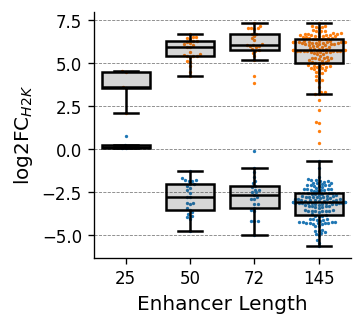

In [21]:
# analysis_df = d3_seq_df[d3_seq_df['design_type']=='fsp_minimal'].copy()
# will also want to grab the fsp_minimal_concatemer...maybe later?
auto_sig = False
save = False

model_types = ['d1_finetuned'] # these are the only model types with targets
# design_types = ['fsp','d2_rand_ctrl','d2_top_ctrl','NC']
design_types = ['fsp_minimal','fsp']
analysis_df = d3_seq_df[(d3_seq_df['model_type'].isin(model_types)) & (d3_seq_df['design_type'].isin(design_types))].copy()
# drop log2(SKNSH_pred) column
analysis_df.drop(columns=['log2(SKNSH)_pred'], inplace=True)
print(analysis_df.shape)

analysis_df['enhancer_len'] = analysis_df['sequence'].apply(len)

# 1 x 2 subplot
fig, ax = plt.subplots(figsize=(2.5*1.25, 2.25*1.25))

palette = {'HEPG2': 'tab:orange', 'K562': 'tab:blue'}

model_type = 'd1_finetuned'

# swarmplot of log2(H2K) vs enhancer_len, with hue=cell_type
# sns.swarmplot(x='enhancer_len',y=H2K_COL,hue='cell_type',data=analysis_df[analysis_df['model_type']==model_type],ax=ax,color='k',size=1.3,alpha=0.3,dodge=True)
# plot boxplot of log2(H2K) vs enhancer_len, with hue=cell_type
# sns.boxplot(x='enhancer_len',y=H2K_COL,hue='cell_type',data=analysis_df[analysis_df['model_type']==model_type],ax=ax,showfliers=False,palette=palette,width=0.75)
# add swarmplot
swarm_alpha=1

# size=2.5, dodge=True,edgecolor='k',linewidth=0.0,zorder=0,alpha=1
sns.swarmplot(x='enhancer_len',y=H2K_COL,data=analysis_df[analysis_df['cell_type']=='HEPG2'],ax=ax,size=2,alpha=swarm_alpha,dodge=True,color='tab:orange',edgecolor='k')
sns.swarmplot(x='enhancer_len',y=H2K_COL,data=analysis_df[analysis_df['cell_type']=='K562'],ax=ax,size=2,alpha=swarm_alpha,dodge=True,color='tab:blue',edgecolor='k')

# boxprops = {'color':'k','facecolor':(0.2,0.2,0.2,0.2)}
# set facecolor of boxprops to be a transparent gray with alpha = 0.2
# boxprops = {'facecolor':(0.2,0.2,0.2,0.2)}
linewidth = 1.5
medianprops = {'color':'k','linewidth':linewidth}
whiskerprops = {'color':'k','linewidth':linewidth}
capprops = {'color':'k','linewidth':linewidth}
# boxprops = {}
boxprops={"facecolor": (.2, .2, .2, .2),'edgecolor':'k','linewidth':linewidth}

sns.boxplot(x='enhancer_len',y=H2K_COL,hue='cell_type',data=analysis_df[analysis_df['cell_type']=='HEPG2'],ax=ax,showfliers=False,width=0.75,
            boxprops=boxprops,medianprops=medianprops,whiskerprops=whiskerprops,capprops=capprops,zorder=20)
sns.boxplot(x='enhancer_len',y=H2K_COL,hue='cell_type',data=analysis_df[analysis_df['cell_type']=='K562'],ax=ax,showfliers=False,width=0.75,
            boxprops=boxprops,medianprops=medianprops,whiskerprops=whiskerprops,capprops=capprops,zorder=20)

# sns.boxplot(x='enhancer_len',y=H2K_COL,hue='cell_type',data=analysis_df[analysis_df['cell_type']=='HEPG2'],ax=ax,showfliers=False,width=0.75,
#             palette='light:gray',linecolor='k',linewidth=0.75,zorder=20)
# sns.boxplot(x='enhancer_len',y=H2K_COL,hue='cell_type',data=analysis_df[analysis_df['cell_type']=='K562'],ax=ax,showfliers=False,width=0.75,
#             palette='light:gray',linecolor='k',linewidth=0.75,zorder=20)

# sns.boxplot(x='enhancer_len',y=H2K_COL,hue='cell_type',data=analysis_df[analysis_df['cell_type']=='HEPG2'],ax=ax,showfliers=False,width=0.75,
#             boxprops=boxprops,medianprops=medianprops,whiskerprops=whiskerprops,capprops=capprops,zorder=20)
# sns.boxplot(x='enhancer_len',y=H2K_COL,hue='cell_type',data=analysis_df[analysis_df['cell_type']=='K562'],ax=ax,showfliers=False,width=0.75,
#             boxprops=boxprops,medianprops=medianprops,whiskerprops=whiskerprops,capprops=capprops,zorder=20)



# sns.swarmplot(x=cur_analysis_df['n_motifs_for_plot'].astype(float),y=cur_analysis_df[score_col],ax=ax,color='k',size=2.5,alpha=0.3)
# sns.boxplot(x='n_motifs_txt',y=score_col,data=cur_analysis_df,fliersize=1,ax=ax,
#             boxprops={'color':'k','facecolor':'white'},
#             medianprops={'color':'orange'},whiskerprops={'color':'k'},capprops={'color':'k'},
#             order=['2','3','4','5','6','7','8+'])

analysis_df['enhancer_len_txt'] = analysis_df['enhancer_len'].astype(str)
if auto_sig:
    statannot.add_stat_annotation(x='enhancer_len_txt',y=H2K_COL,data=analysis_df[analysis_df['cell_type']=='HEPG2'],ax=ax,order=['25','50','72','145'],
                                box_pairs=[('25','50')],
                                test='Mann-Whitney',text_format='star',loc='outside',verbose=2,comparisons_correction='bonferroni')

    statannot.add_stat_annotation(x='enhancer_len_txt',y=H2K_COL,data=analysis_df[analysis_df['cell_type']=='K562'],ax=ax,order=['25','50','72','145'],
                                    box_pairs=[('25','50')],
                                    test='Mann-Whitney',text_format='star',loc='outside',verbose=2,comparisons_correction='bonferroni')


# set x axis label
ax.set_xlabel('Enhancer Length',fontsize=AXIS_FSIZE)
# set y axis label
ax.set_ylabel('log2FC$_{H2K}$',fontsize=AXIS_FSIZE)
# set title
ax.set_title(f'')
# add horizontal grid lines
ax.grid(axis='y',color='gray',linestyle='--',linewidth=0.5)
# remove legend
ax.legend_.remove()
# despine
sns.despine()
# set xtick font size
ax.tick_params(axis='x', labelsize=TEXT_FSIZE)
# set ytick font size
ax.tick_params(axis='y', labelsize=TEXT_FSIZE)

# save
plt.tight_layout()

# if save:
plt.savefig(f'{fig4_dir}/fig4_minimal_boxplots.png',dpi=600,bbox_inches='tight')

### MEH I COULD TRY TO MAKE THIS INTO A BACK-TO-BACK BARPLOT INSTEAD, THAT MIGHT LOOK BETTER/VARY THINGS UP MORE, MEH ###

### Fig 4X: comparing best enhancers of each sequence length ###

In [3]:
# I want to compare the best minimal enhancers to the best overall enhancers
model_types = ['d1_finetuned','d2_dhs','d2_meas'] # these are the only model types with targets
# design_types = ['fsp','d2_rand_ctrl','d2_top_ctrl','NC']
# design_types = ['fsp_minimal','fsp','fsp_tgt','nonmotif_masked_fsp','d2_rand_ctrl','d2_top_ctrl','fsp_minimal_concatemer']
design_types = ['fsp_minimal','fsp','fsp_tgt','d2_rand_ctrl','d2_top_ctrl']
analysis_df = d3_seq_df[(d3_seq_df['model_type'].isin(model_types)) & (d3_seq_df['design_type'].isin(design_types))].copy()

analysis_df['enhancer_len'] = analysis_df['sequence'].apply(len)

In [4]:
best_hepg2_25bp_enhancer = analysis_df.loc[analysis_df['enhancer_len']==25].sort_values(by=H2K_COL,ascending=False).iloc[0]['sequence_name']
best_hepg2_50bp_enhancer = analysis_df.loc[analysis_df['enhancer_len']==50].sort_values(by=H2K_COL,ascending=False).iloc[0]['sequence_name']
best_hepg2_72bp_enhancer = analysis_df.loc[analysis_df['enhancer_len']==72].sort_values(by=H2K_COL,ascending=False).iloc[0]['sequence_name']
best_hepg2_145bp_enhancer = analysis_df.loc[(analysis_df['enhancer_len']==145)&(analysis_df['design_type']!='fsp_minimal_concatemer')].sort_values(by=H2K_COL,ascending=False).iloc[0]['sequence_name']
best_hepg2_min_enhancer = analysis_df.loc[analysis_df['design_type']=='fsp_minimal'].sort_values(by=H2K_COL,ascending=False).iloc[0]['sequence_name']

best_k562_25bp_enhancer = analysis_df.loc[analysis_df['enhancer_len']==25].sort_values(by=H2K_COL,ascending=True).iloc[0]['sequence_name']
best_k562_50bp_enhancer = analysis_df.loc[analysis_df['enhancer_len']==50].sort_values(by=H2K_COL,ascending=True).iloc[0]['sequence_name']
best_k562_72bp_enhancer = analysis_df.loc[analysis_df['enhancer_len']==72].sort_values(by=H2K_COL,ascending=True).iloc[0]['sequence_name']
best_k562_145bp_enhancer = analysis_df.loc[(analysis_df['enhancer_len']==145)&(analysis_df['design_type']!='fsp_minimal_concatemer')].sort_values(by=H2K_COL,ascending=True).iloc[0]['sequence_name']
best_k562_min_enhancer = analysis_df.loc[analysis_df['design_type']=='fsp_minimal'].sort_values(by=H2K_COL,ascending=True).iloc[0]['sequence_name']

print(best_hepg2_25bp_enhancer)
print(best_hepg2_50bp_enhancer)
print(best_hepg2_72bp_enhancer)
print(best_hepg2_145bp_enhancer)
print(best_hepg2_min_enhancer) # okay this is the 72bp enhancer

print(best_k562_25bp_enhancer)
print(best_k562_50bp_enhancer)
print(best_k562_72bp_enhancer)
print(best_k562_145bp_enhancer)
print(best_k562_min_enhancer) # this is also the 72bp enhancer

designed_d1_finetuned_fsp_target_0_HEPG2_seq_min25_4
designed_d1_finetuned_fsp_target_0_HEPG2_seq_min50_12
designed_d1_finetuned_fsp_target_0_HEPG2_seq_min72_25
designed_d1_finetuned_fsp_target_0_HEPG2_seq_136
designed_d1_finetuned_fsp_target_0_HEPG2_seq_min72_25
designed_d1_finetuned_fsp_target_1_K562_seq_min25_4
designed_d1_finetuned_fsp_target_1_K562_seq_min50_7
designed_d1_finetuned_fsp_target_1_K562_seq_min72_19
designed_d2_dhs_fsp_target_1_K562_seq_70
designed_d1_finetuned_fsp_target_1_K562_seq_min72_19


In [5]:
for _,row in analysis_df.sort_values(by=H2K_COL,ascending=False).head(10).iterrows():
    print(row['sequence_name'], row['design_type'],row['model_type'])
    print(f'{row[H2K_COL]:.3f}')

designed_d1_finetuned_fsp_target_0_HEPG2_seq_min72_25 fsp_minimal d1_finetuned
7.368
designed_d1_finetuned_fsp_target_0_HEPG2_seq_136 fsp d1_finetuned
7.337
designed_d2_dhs_fsp_target_0_HEPG2_seq_48 fsp d2_dhs
7.229
designed_d2_dhs_fsp_target_0_HEPG2_seq_8 fsp d2_dhs
7.216
designed_d1_finetuned_fsp_target_0_HEPG2_seq_72 fsp d1_finetuned
7.181
designed_d1_finetuned_fsp_target_0_HEPG2_seq_74 fsp d1_finetuned
7.177
designed_d1_finetuned_fsp_target_0_HEPG2_seq_min72_9 fsp_minimal d1_finetuned
7.176
designed_d1_finetuned_fsp_target_0_HEPG2_seq_10 fsp d1_finetuned
7.119
designed_d1_finetuned_fsp_target_0_HEPG2_seq_75 fsp d1_finetuned
7.113
designed_d1_finetuned_fsp_target_0_HEPG2_seq_min72_2 fsp_minimal d1_finetuned
7.066


47 clusters
HEPG2 clusters: 4
K562 clusters: 5
2.0


C:\Users\Chris\AppData\Local\Temp\ipykernel_19072\3166801601.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bluesBig = matplotlib.cm.get_cmap('Blues', 512)
C:\Users\Chris\AppData\Local\Temp\ipykernel_19072\3166801601.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orangesBig = matplotlib.cm.get_cmap('Oranges', 512)


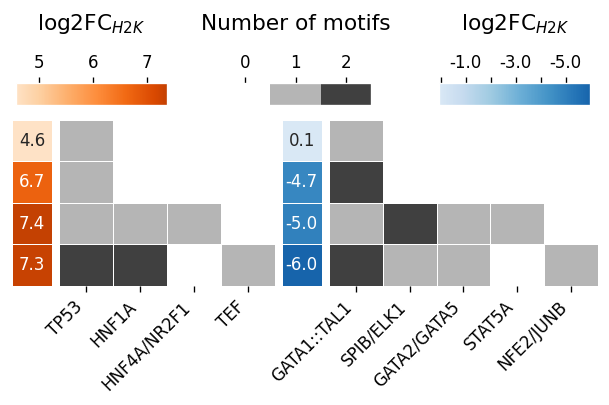

In [24]:
### Okay prototype cluster heatmaps for top enhancers of each sequence length ###

hepg2_top_enhancer_seqs = [best_hepg2_25bp_enhancer,best_hepg2_50bp_enhancer,best_hepg2_72bp_enhancer,best_hepg2_145bp_enhancer]
k562_top_enhancer_seqs  = [best_k562_25bp_enhancer,best_k562_50bp_enhancer,best_k562_72bp_enhancer,best_k562_145bp_enhancer]

# create new numpy array that's n_seqs x n_clusters
analysis_df = d3_deseq_plus_cluster_cnts_df.copy()
analysis_df['enhancer_len'] = analysis_df['sequence'].apply(lambda x: len(str(x)))
clusters = np.array([col for col in analysis_df.columns if col.startswith('cluster_')])
print(f'{len(clusters)} clusters')

hepg2_df = analysis_df[analysis_df['sequence_name'].isin(hepg2_top_enhancer_seqs)]
k562_df = analysis_df[analysis_df['sequence_name'].isin(k562_top_enhancer_seqs)]
# sort hepg2_df in descending order of log2FoldChange_H2K_deseq
hepg2_df = hepg2_df.sort_values(by='enhancer_len',ascending=True)
# sort k562_df in ascending order of log2FoldChange_H2K_deseq
k562_df = k562_df.sort_values(by='enhancer_len',ascending=True)

hepg2_sort_inds = np.argsort(np.array(hepg2_df[clusters]).sum(axis=0))[::-1]
k562_sort_inds = np.argsort(np.array(k562_df[clusters]).sum(axis=0))[::-1]

###########################################################################################

n_seqs = 4 # get one seq per each enhancer len

hepg2_df_filt = hepg2_df.head(n_seqs)
k562_df_filt = k562_df.head(n_seqs)

hepg2_clusters = np.array([cluster for cluster in clusters if np.array(hepg2_df_filt[cluster]).sum()>0])
k562_clusters = np.array([cluster for cluster in clusters if np.array(k562_df_filt[cluster]).sum()>0])

print(f'HEPG2 clusters: {len(hepg2_clusters)}')
print(f'K562 clusters: {len(k562_clusters)}')

# okay let's redo those heatmaps now!

hepg2_max = hepg2_df_filt[hepg2_clusters].max().max()
k562_max = k562_df_filt[k562_clusters].max().max()

global_max = max(hepg2_max,k562_max)
print(global_max)

vmin = 0
# vmax = dw_deseq_plus_cluster_cnts_df['n_motifs'].max()
vmax = global_max

# make the cmap for heatmap
n_colors = int(vmax-vmin+1)
colors = plt.cm.Greys(np.linspace(0, 0.8, n_colors))
# colors = plt.cm.Greys(np.array([0,0.3,0.4,0.5,0.6,0.7]))
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_colors)

# set h2k_vmax to be the max abs H2K_COL between hepg2_df_filt and k562_df_filt
h2k_vmax = max(abs(hepg2_df_filt[H2K_COL]).max(),abs(k562_df_filt[H2K_COL]).max())
# set h2k_vmin to be min abs H2K_COL between hepg2_df_filt and k562_df_filt
h2k_vmin = min(abs(hepg2_df_filt[H2K_COL]).min(),abs(k562_df_filt[H2K_COL]).min())

# plot np.array(hepg2_df_filt[hepg2_clusters]) as heatmap with rows corresponding to sequences and columns the motifs
n_clusters_to_plot = np.max((len(hepg2_clusters),len(k562_clusters)))
hepg2_filt_sort_inds = np.argsort(np.array(hepg2_df_filt[hepg2_clusters]).sum(axis=0))[::-1][:n_clusters_to_plot]
k562_filt_sort_inds = np.argsort(np.array(k562_df_filt[k562_clusters]).sum(axis=0))[::-1][:n_clusters_to_plot]

### Begin actual plotting code ###

bluesBig = matplotlib.cm.get_cmap('Blues', 512)
blues_trunc_cm = matplotlib.colors.ListedColormap(bluesBig(np.linspace(0.15, 0.8, 256)))
# create reverse version of blues_trunc_cm
blues_trunc_cm_r = matplotlib.colors.ListedColormap(bluesBig(np.linspace(0.8, 0.15, 256)))

orangesBig = matplotlib.cm.get_cmap('Oranges', 512)
oranges_trunc_cm = matplotlib.colors.ListedColormap(orangesBig(np.linspace(0.15, 0.8, 256)))

# set figure width based on number of clusters, using a constant width_per_cluster
width_per_cluster = 5
# fig_width = width_per_cluster * len(hepg2_clusters)
fig_width = width_per_cluster *(len(hepg2_clusters)+len(k562_clusters))

# make 2 side by side subplots
# 4 hepg2 motifs, 5 k562 motifs so axis ratios should be 4:5

# make 2 side by side subplots
# fig, (ax0, ax1,ax2,ax3) = plt.subplots(1,4,figsize=(7,4),sharey=True,gridspec_kw={'width_ratios': [1,1,1,8]})
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4,figsize=(7*.9,2*.9),sharey=True,gridspec_kw={'width_ratios': [1.5,8,1.5,10]})

# plot hepg2 cluster heatmap
sns.heatmap(np.array(hepg2_df_filt[hepg2_clusters])[:,hepg2_filt_sort_inds],xticklabels=hepg2_clusters[hepg2_filt_sort_inds],
            cmap=cmap,cbar=False,ax=ax1,vmin=vmin,vmax=vmax,edgecolor='white',linewidth=0.5)
# remove yticks
ax1.set_yticks([])
# ax1.set_title(f'HEPG2')
ax1.set_xticklabels([cluster_name_dict[cluster] for cluster in hepg2_clusters[hepg2_filt_sort_inds]],fontsize=TEXT_FSIZE,rotation=45,ha='right')

# plot hepg2 log2(H2K) heatmap:
sns.heatmap(hepg2_df_filt[H2K_COL].values.reshape(-1, 1), cmap=oranges_trunc_cm, cbar=False, ax=ax0,annot=True,
            fmt='.1f',edgecolor='white',linewidth=0.5) #,vmin=h2k_vmin,vmax=h2k_vmax

# plot k562 cluster heatmap
sns.heatmap(np.array(k562_df_filt[k562_clusters])[:,k562_filt_sort_inds],xticklabels=k562_clusters[k562_filt_sort_inds],
            cmap=cmap,cbar=False,ax=ax3,vmin=vmin,vmax=vmax,edgecolor='white',linewidth=0.5)
# remove yticks
ax3.set_yticks([])
# ax3.set_title(f'K562')
ax3.set_xticklabels([cluster_name_dict[cluster] for cluster in k562_clusters[k562_filt_sort_inds]],fontsize=TEXT_FSIZE,rotation=45,ha='right')

# plot k562 log2(H2K) heatmap:
sns.heatmap(k562_df_filt[H2K_COL].values.reshape(-1, 1), cmap=blues_trunc_cm_r, cbar=False, ax=ax2,annot=True,
            fmt='.1f',edgecolor='white',linewidth=0.5) #,vmin=-h2k_vmax,vmax=-h2k_vmin

# set overall figure title
# fig.suptitle(f'Motifs in top {int(percentile*100)}% of sequences\n')

### add colorbars ###

cbar_height = 0.1

# add colorbar for n_motifs
from matplotlib.ticker import MaxNLocator
cbar_ax = fig.add_axes([0.4, 0.95, 0.2, cbar_height])

boundaries = np.linspace(vmin - 0.5, vmax + 0.5, n_colors + 1)
ticks = np.arange(vmin, vmax + 1)

cb = fig.colorbar(ax1.collections[0], cax=cbar_ax,orientation='horizontal',label='Number of motifs',shrink=0.01,drawedges=False,boundaries=boundaries,ticks=ticks,format="%d")
# plt.colorbar(ticks=ticks, boundaries=boundaries, format="%d", orientation='vertical')
# cb = fig.colorbar(ax1.collections[0], cax=cbar_ax,orientation='horizontal',label='Number of motifs',shrink=0.01,drawedges=False,boundaries=np.arange(0,vmax+1,1),ticks=np.arange(0,vmax+1,1))
cbar_ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cbar_ax.xaxis.tick_top()
# move title of cbar_ax to above the colorbar
cbar_ax.set_title('Number of motifs',fontsize=AXIS_FSIZE+1,y=3)
# remove x and y labels
cbar_ax.set_xlabel('')
cbar_ax.set_ylabel('')
# set cb outline to white
cb.outline.set_edgecolor('white')
# set cb ticks to ticks
cb.set_ticks(ticks=ticks,labels=np.arange(vmin,vmax+1).astype(int))

# add colorbar for H2K for HEPG2 seqs to the left of cbar_ax
cbar_ax_hepg2_h2k = fig.add_axes([0.13, 0.95, 0.2, cbar_height])
cb_hepg2 = fig.colorbar(ax0.collections[0], cax=cbar_ax_hepg2_h2k,orientation='horizontal',label='log2(HEPG2/K562)',shrink=0.01,drawedges=False)
cbar_ax_hepg2_h2k.xaxis.set_major_locator(MaxNLocator(integer=True))
# move ticks above colorbar
cbar_ax_hepg2_h2k.xaxis.tick_top()
# move title of cbar_ax to above the colorbar
cbar_ax_hepg2_h2k.set_title('log2FC$_{H2K}$',fontsize=AXIS_FSIZE+1,y=3)
# remove x and y labels
cbar_ax_hepg2_h2k.set_xlabel('')
cbar_ax_hepg2_h2k.set_ylabel('')
# set colorbar outline to white
cb_hepg2.outline.set_edgecolor('white')


# add colorbar for H2K for K562 seqs to the right of cbar_ax
cbar_ax_k562_h2k = fig.add_axes([0.69, 0.95, 0.2, cbar_height]) # x, y, width, height
cb_k562 = fig.colorbar(ax2.collections[0], cax=cbar_ax_k562_h2k,orientation='horizontal',label='log2(K562/HEPG2)',shrink=0.01,drawedges=False)
cbar_ax_k562_h2k.xaxis.set_major_locator(MaxNLocator(integer=True))
# move ticks above colorbar
cbar_ax_k562_h2k.xaxis.tick_top()
# move title of cbar_ax to above the colorbar
cbar_ax_k562_h2k.set_title('log2FC$_{H2K}$',fontsize=AXIS_FSIZE+1,y=3)
# remove x and y labels
cbar_ax_k562_h2k.set_xlabel('')
cbar_ax_k562_h2k.set_ylabel('')
# set tick formating to .1f
# impoer FormatStrFormatter from matplotlib.ticker
from matplotlib.ticker import FormatStrFormatter
cbar_ax_k562_h2k.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# reverse the order of the colorbar
cbar_ax_k562_h2k.invert_xaxis()
# set colorbar outline to white
cb_k562.outline.set_edgecolor('white')


# cbar = fig.colorbar(sns.heatmap(np.array(hepg2_df_filt[hepg2_clusters])[:,hepg2_filt_sort_inds],xticklabels=hepg2_clusters[hepg2_filt_sort_inds],cmap='bone_r',cbar=False,ax=ax1,vmin=vmin,vmax=vmax),cax=cbar_ax,orientation='horizontal')

# only show integer xticks on colorbar
# import MaxNLocator from matplotlib.ticker

# remove yticks from ax0 and ax2
ax0.set_yticks([])
ax2.set_yticks([])
# remove xticks from ax0 and ax2
ax0.set_xticks([])
ax2.set_xticks([])
# decrease space between ax0 and ax1
plt.subplots_adjust(wspace=0.05)


# insert space between ax1 and ax2

# # plot every other xtick label on cbar_ax_hepg2_h2k
# for i,tick in enumerate(cbar_ax_hepg2_h2k.get_xticklabels()):
#     if i%2==0:
#         tick.set_visible(False)

# plot every other xtick label on cbar_ax_k562_h2k
for i,tick in enumerate(cbar_ax_k562_h2k.get_xticklabels()):
    if i%2==0:
        tick.set_visible(False)



# save figure at 600 dpi
plt.savefig(f'{fig4_dir}/minimal_motif_heatmap.png',dpi=600,bbox_inches='tight')

plt.show()

In [19]:
# let's do the wilcoxon rank-sum test for each enhancer length, within each model type, within each cell type

results_df = pd.DataFrame(columns=['model_type','cell_type','len1','len2','len1_median','len2_median','p'])

enhancer_lens = analysis_df['enhancer_len'].unique()
enhancer_lens.sort()
# get all consecutive pairs of enhancer lengths
enhancer_len_pairs = list(zip(enhancer_lens[:-1],enhancer_lens[1:]))
n_cell_lines = 2
n_model_types = len(model_types)
n_tests = len(enhancer_len_pairs)*n_cell_lines*n_model_types
sig_thresh = 5e-2
for model_type in model_types:
    print(f'Evaluating {model_type}...')
    cur_analysis_df = analysis_df[analysis_df['model_type']==model_type]
    for cell_type in ['HEPG2','K562']:
        print(f'\t{cell_type}...')
        # compare each enhancer length to the next highest enhancer length

        for l1,l2 in enhancer_len_pairs:

            # perform wilcoxon rank-sum test for each pair of targets
            s,p = ranksums(cur_analysis_df[(cur_analysis_df['cell_type']==cell_type) & (cur_analysis_df['enhancer_len']==l1)][H2K_COL],\
                            cur_analysis_df[(cur_analysis_df['cell_type']==cell_type) & (cur_analysis_df['enhancer_len']==l2)][H2K_COL])
            
            l1_median = np.median(cur_analysis_df[(cur_analysis_df['cell_type']==cell_type) & (cur_analysis_df['enhancer_len']==l1)][H2K_COL])
            l2_median = np.median(cur_analysis_df[(cur_analysis_df['cell_type']==cell_type) & (cur_analysis_df['enhancer_len']==l2)][H2K_COL])

            sig_str = "*"*10 if p * n_tests < sig_thresh else ""
            print(f'\t\t{l1} vs {l2} p = {p:>14.2E} {sig_str}')
            # append to results_df using concat
            results_df = pd.concat([results_df,pd.DataFrame({'model_type': [model_type],
                                                            'cell_type': [cell_type],
                                                            'len1': [l1],
                                                            'len2': [l2],
                                                            'len1_median': l1_median,
                                                            'len2_median': l2_median,
                                                            'p': [p]})])

Evaluating d1_finetuned...
	HEPG2...
		25 vs 50 p =       9.29E-04 **********
		50 vs 72 p =       6.12E-02 
		72 vs 145 p =       2.76E-02 
	K562...
		25 vs 50 p =       5.05E-04 **********
		50 vs 72 p =       9.46E-01 
		72 vs 145 p =       4.69E-02 


C:\Users\Chris\AppData\Local\Temp\ipykernel_22492\2795229109.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df,pd.DataFrame({'model_type': [model_type],


In [20]:
results_df

,model_type,cell_type,len1,len2,len1_median,len2_median,p
0,d1_finetuned,HEPG2,25,50,3.620166,5.964549,0.000929
0,d1_finetuned,HEPG2,50,72,5.964549,6.084506,0.061155
0,d1_finetuned,HEPG2,72,145,6.084506,5.803444,0.027639
0,d1_finetuned,K562,25,50,0.146995,-2.753818,0.000505
0,d1_finetuned,K562,50,72,-2.753818,-2.649534,0.945857
0,d1_finetuned,K562,72,145,-2.649534,-3.084117,0.046946


### Fig 4B: Minimal Enhancer motif heatmap ###

In [49]:
model_types = ['d1_finetuned'] # these are the only model types with targets
# design_types = ['fsp','d2_rand_ctrl','d2_top_ctrl','NC']
design_types = ['fsp_minimal','fsp']
analysis_df = d3_deseq_plus_cluster_cnts_df[(d3_deseq_plus_cluster_cnts_df['model_type'].isin(model_types)) & (d3_deseq_plus_cluster_cnts_df['design_type'].isin(design_types))].copy()
# drop log2(SKNSH_pred) column
analysis_df.drop(columns=['log2(SKNSH)_pred'], inplace=True)
print(analysis_df.shape)

analysis_df['enhancer_len'] = analysis_df['sequence'].apply(len)

cluster_cols = [col for col in analysis_df.columns if 'cluster_' in col]
print(len(cluster_cols))
# drop all cluster_cols with all 0 entries
analysis_df.drop(columns=[col for col in cluster_cols if analysis_df[col].sum()==0], inplace=True)
cluster_cols = [col for col in analysis_df.columns if 'cluster_' in col]
print(len(cluster_cols))

analysis_df['n_motifs/bp'] = analysis_df['n_motifs'] / analysis_df['enhancer_len']

(368, 66)
47
24


In [50]:
### Okay let's try making a dataframe combining both cell types

# okay, let's start off within each cell type, drop all clusters not used in this cell type
cur_analysis_df = analysis_df.copy()
# dropp all nonzero cluster columns
cluster_cols = [col for col in analysis_df.columns if 'cluster_' in col]
cur_analysis_df.drop(columns=[col for col in cluster_cols if cur_analysis_df[col].sum()==0], inplace=True)
cluster_cols = [col for col in cur_analysis_df.columns if 'cluster_' in col]
print(len(cluster_cols))

# calculate total cluster count / number of rows for each cluster, grouped by enhancer_len
# hepg2_cluster_freq_df = cluster_freq_df[cluster_freq_df['cell_type']=='HEPG2'].copy()
# hepg2_cluster_freq_df.drop(columns='cell_type',inplace=True)
# hepg2_cluster_freq_df_T = hepg2_cluster_freq_df.set_index('enhancer_len').transpose()
# hepg2_cluster_freq_df_T.index.name = 'cluster'

# k562_cluster_freq_df = cluster_freq_df[cluster_freq_df['cell_type']=='K562'].copy()
# k562_cluster_freq_df.drop(columns='cell_type',inplace=True)
# k562_cluster_freq_df_T = k562_cluster_freq_df.set_index('enhancer_len').transpose()
# k562_cluster_freq_df_T.index.name = 'cluster'

cluster_freq_df_T = pd.DataFrame()
n_cluster_vec = []

for cell_type in ['HEPG2','K562']:
    cur_analysis_df = analysis_df[analysis_df['cell_type']==cell_type].copy()
    cluster_cols = [col for col in analysis_df.columns if 'cluster_' in col]
    cur_analysis_df.drop(columns=[col for col in cluster_cols if cur_analysis_df[col].sum()==0], inplace=True)
    cluster_cols = [col for col in cur_analysis_df.columns if 'cluster_' in col]

    cluster_freq_df = cur_analysis_df.groupby(['enhancer_len'])[cluster_cols].sum().reset_index()
    # divide each cluster count by number of sequences with that enhancer_len
    for enhancer_len in cluster_freq_df['enhancer_len'].unique():
        cluster_freq_df.loc[cluster_freq_df['enhancer_len']==enhancer_len,cluster_cols] = cluster_freq_df.loc[cluster_freq_df['enhancer_len']==enhancer_len,cluster_cols] / cur_analysis_df.loc[cur_analysis_df['enhancer_len']==enhancer_len].shape[0]

    # dropp all clusters where the max frequency across all enhancer_lens is less than 0.1
    freq_thresh = 0.05
    cluster_freq_df.drop(columns=[col for col in cluster_cols if cluster_freq_df[col].max() < freq_thresh], inplace=True)
    cluster_cols = [col for col in cluster_freq_df.columns if 'cluster_' in col]
    n_cluster_vec += [len(cluster_cols)]


    cur_cluster_freq_df_T = cluster_freq_df.set_index('enhancer_len').transpose()
    cur_cluster_freq_df_T.index.name = 'cluster'
    cur_cluster_freq_df_T.sort_values(by=145,ascending=(cell_type=='K562'),inplace=True)
    

    cluster_freq_df_T = pd.concat([cluster_freq_df_T,cur_cluster_freq_df_T])
# also, I want to define frequency metric! Honestly, I think n_motifs / n_seqs is better than previous frequency metrics, and perhaps I will redo prior analyses with this metric

24


In [11]:
cluster_freq_df.head()

,enhancer_len,cluster_1,cluster_9,cluster_18,cluster_11,cluster_120
0,25,0.000000,0.000000,0.000000,0.000000,1.000000
1,50,0.560000,0.560000,0.000000,0.240000,0.920000
2,72,1.000000,0.800000,0.000000,0.440000,1.040000
3,145,1.775194,1.852713,0.193798,0.875969,1.348837


In [10]:
cluster_freq_df_T.head()

enhancer_len,25,50,72,145
cluster,,,,
cluster_50,1.0,0.92,0.96,1.612403
cluster_2,0.0,0.44,0.84,1.372093
cluster_41,0.0,0.24,0.44,0.612403
cluster_5,0.0,0.04,0.24,0.449612
cluster_4,0.0,0.08,0.20,0.449612


C:\Users\Chris\AppData\Local\Temp\ipykernel_27480\1287130499.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greysBig = matplotlib.cm.get_cmap('Greys', 512)


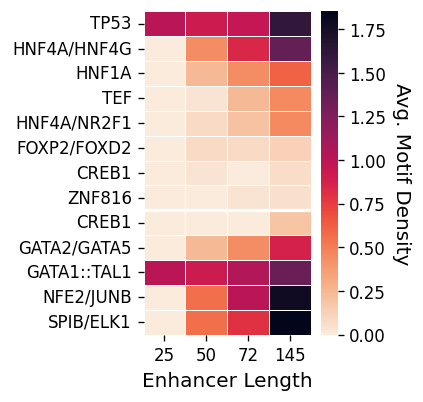

In [54]:
# cluster_freq_df_T = cluster_freq_df.set_index('enhancer_len').transpose()
# # rename enhancer_len column to cluster
# cluster_freq_df_T.index.name = 'cluster'

greysBig = matplotlib.cm.get_cmap('Greys', 512)
greys_freq_cm = matplotlib.colors.ListedColormap(greysBig(np.linspace(0.15, 0.9, 256)))

# plot heatmap
plt.figure(figsize=(2.25,3.5))
sns.heatmap(cluster_freq_df_T,cmap='rocket_r',edgecolor='white',linewidth=0.5)
plt.xlabel('Enhancer Length',fontsize=AXIS_FSIZE)
plt.ylabel('',fontsize=AXIS_FSIZE)
plt.title(f'',fontsize=TITLE_FSIZE)
plt.xticks(fontsize=TEXT_FSIZE)
plt.yticks(fontsize=TEXT_FSIZE)
# set xticklabels to cluster_name_dict[cluster]
ytick_labels = [tick.get_text() for tick in plt.yticks()[1]]
yticks = plt.yticks()[0]
plt.yticks(ticks=yticks,labels=[cluster_name_dict[cluster] for cluster in ytick_labels])

# label colorbar 'Frequency'
cbar = plt.gcf().axes[-1]
cbar.set_ylabel('Avg. Motif Density',fontsize=AXIS_FSIZE,rotation=270,labelpad=15)

# draw a white line between the two cell types, at n_cluster_vec[0]
plt.axhline(y=n_cluster_vec[0],color='white',linewidth=2)

# draw an orange rectangle around the HEPG2 clusters
# plt.axhspan(0,n_cluster_vec[0],facecolor='none',edgecolor='tab:orange',linewidth=1.5)
# # draw a blue rectangle around the K562 clusters
# plt.axhspan(n_cluster_vec[0],n_cluster_vec[0]+n_cluster_vec[1],facecolor='none',edgecolor='tab:blue',linewidth=1.5)
# save figure at 600 dpi
plt.savefig(f'{fig4_dir}/fig4_minimal_cluster_freq_heatmap_rocket_r.png',dpi=600,bbox_inches='tight')

### Fig 3I: Nonmotif seq optimization swarmplot ###

In [39]:
model_types = ['d1_finetuned','shuffled_nonmotif'] # these are the only model types with targets
# design_types = ['fsp','d2_rand_ctrl','d2_top_ctrl','NC']
design_types = ['nonmotif_masked_fsp','shuffled_nonmotif']
analysis_df = d3_deseq_plus_cluster_cnts_df[(d3_deseq_plus_cluster_cnts_df['model_type'].isin(model_types)) & (d3_deseq_plus_cluster_cnts_df['design_type'].isin(design_types))].copy()
# drop log2(SKNSH_pred) column
analysis_df.drop(columns=['log2(SKNSH)_pred'], inplace=True)
print(analysis_df.shape)

# extract original sequence index from sequence name
analysis_df.loc[analysis_df['design_type']=='nonmotif_masked_fsp','og_seq_idx'] = analysis_df.loc[analysis_df['design_type']=='nonmotif_masked_fsp','sequence_name'].apply(lambda x: int(x.split('_')[-3][3:]))
analysis_df.loc[analysis_df['design_type']=='shuffled_nonmotif','og_seq_idx'] = analysis_df.loc[analysis_df['design_type']=='shuffled_nonmotif','sequence_name'].apply(lambda x: int(x.split('_')[0]))
# set og_seq_idx to int
analysis_df['og_seq_idx'] = analysis_df['og_seq_idx'].astype(int)

# # replace 1041 with 22263 (1041 is d2 index, 22263 is d1 index)
# analysis_df.loc[analysis_df['og_seq_idx']==1041,'og_seq_idx'] = 22263

# extract unmodified sequence
for d2_seq_idx in analysis_df['og_seq_idx'].unique():
    if f'd2_seq_{d2_seq_idx:.0f}' in d3_seq_df['sequence_name'].values:
        # print(f'{d2_seq_idx:.0f} is in d3_seq_df')
        # append this row to analysis_df using pd.concat
        analysis_df = pd.concat([analysis_df,d3_deseq_plus_cluster_cnts_df[d3_deseq_plus_cluster_cnts_df['sequence_name']==f'd2_seq_{d2_seq_idx:.0f}']])     
    # elif f'd1_seq_{d2_seq_idx:.0f}' in d3_seq_df['sequence_name'].values:
    #     analysis_df = pd.concat([analysis_df,d3_deseq_plus_cluster_cnts_df[d3_deseq_plus_cluster_cnts_df['sequence_name']==f'd1_seq_{d2_seq_idx:.0f}']]) 
    else:
        print(f'Error: {d2_seq_idx} is NOT in d3_seq_df')

analysis_df.loc[analysis_df['model_type']=='d2_meas','og_seq_idx'] = analysis_df.loc[analysis_df['model_type']=='d2_meas','sequence_name'].apply(lambda x: int(x.split('_')[2]))


# append d2 1041, which is actually d1 22263
analysis_df = pd.concat([analysis_df,d3_deseq_plus_cluster_cnts_df[d3_deseq_plus_cluster_cnts_df['sequence_name']==f'd1_seq_22263']])
analysis_df.loc[analysis_df['model_type']=='d2_meas','og_seq_idx'] = analysis_df.loc[analysis_df['model_type']=='d2_meas','sequence_name'].apply(lambda x: int(x.split('_')[2]))

# set og_seq_idx 22263 to 1041
analysis_df.loc[analysis_df['og_seq_idx']==22263,'og_seq_idx'] = 1041

# sort_order = analysis_df[analysis_df['model_type']=='d2_meas'].sort_values(H2K_COL,ascending=False).index
sort_order = analysis_df[analysis_df['model_type']=='d2_meas'].sort_values(H2K_COL,ascending=False)['og_seq_idx'].values
# flip sign for K562 seqs to use same axis
analysis_df.loc[analysis_df['cell_type']=='K562',H2K_COL] *= -1

(149, 66)
Error: 1041 is NOT in d3_seq_df


In [40]:
# calculate improvement for a given sequence (note H2K has been absolute valued already so can take max of everything)
cur_seq_idx = 335
og_156_h2k = analysis_df.loc[analysis_df['sequence_name']==f'd2_seq_{cur_seq_idx}',H2K_COL].values[0]
best_156_h2k = analysis_df.loc[analysis_df['og_seq_idx']==cur_seq_idx,H2K_COL].max()
print(f'Seq 156 improvement: {best_156_h2k:.2f} / {og_156_h2k:.2f} = {best_156_h2k/og_156_h2k:.2f}')

Seq 156 improvement: 7.35 / 5.52 = 1.33


In [128]:
analysis_df['og_seq_idx'].value_counts()

og_seq_idx
433.0     16
905.0     16
633.0     16
335.0     16
976.0     16
1041.0    16
762.0     16
156.0     16
1099.0    16
667.0     15
Name: count, dtype: int64

In [14]:
analysis_df[analysis_df['model_type']=='d2_meas'].sort_values(H2K_COL,ascending=False)['og_seq_idx'].values

array([ 433.,  905.,  976.,  667.,  335., 1099.,  633.,  762.,  156.])

In [64]:
analysis_df[analysis_df['model_type']=='d2_meas'].sort_values(H2K_COL,ascending=False)['og_seq_idx'].values

array([ 433.,  905., 1099.,  976.,  335., 1041.,  762.,  667.,  633.,
        156.])

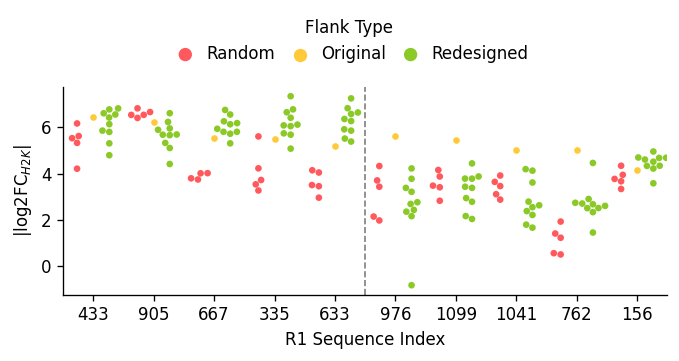

In [41]:
palette = {
    'shuffled_nonmotif': '#FF595E',
    'd2_top_ctrl': '#FFCA3A',
    'nonmotif_masked_fsp': '#8AC926'
    
}
# get sort order as the descending order of H2K_COL for the original sequence
og_seqs = analysis_df['og_seq_idx'].unique()

# set hue_order to shuffled_nonmotif, d2_top_ctrl, nonmotif_masked_fsp
hue_order = ['shuffled_nonmotif','d2_top_ctrl','nonmotif_masked_fsp']

# reverse the order of the second half of the sort_inds
sort_order = np.concatenate([sort_order[:len(sort_order)//2],sort_order[len(sort_order)//2:][::-1]])

plt.figure(figsize=(6.5,2.25))
# plot a beeswarm where x axis is the og_seq_idx and hue is the design_type
sns.swarmplot(x='og_seq_idx',y=H2K_COL,hue='design_type',hue_order=hue_order,data=analysis_df,order=sort_order,
              size=4,edgecolor='k',linewidth=0.0,dodge=True,palette=palette)
# place legend outside of plot
# set legend labels to 'Random', 'Original', 'FSP-optimized', with large marker size
# plt.legend(loc='upper left',bbox_to_anchor=(1.01,1.01),fontsize=TEXT_FSIZE,markerscale=2)
plt.legend(loc='upper left', bbox_to_anchor=(0.15, 1.4),frameon=False,fontsize=TEXT_FSIZE,title_fontsize=TEXT_FSIZE,
           labels=['Random','Original','Redesigned'],title='Flank Type',markerscale=2,ncol=3,handletextpad=0.25,columnspacing=0.5)
# plot legend centered at top of plot
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),frameon=False,fontsize=TEXT_FSIZE,markerscale=2)
# move legend to bottom left of plot, 1 row
plt.xlabel('R1 Sequence Index')
plt.ylabel('|log2FC$_{H2K}$|')
# plt.title('Nonmotif optimization')

# get current xticks
xticks = plt.xticks()[0]
xtick_labels = [f'{int(x):.0f}' for x in sort_order]
# set xtick labels
plt.xticks(xticks,xtick_labels)

# add horizontal grid lines
# plt.grid(axis='y',color='gray',linestyle='--',linewidth=0.5)

# plot vertical line at 4.5
plt.axvline(x=4.5,color='k',linewidth=1,linestyle='--',alpha=0.5)

# despine
sns.despine()

# save figure
plt.savefig(f'{fig3_dir}/fig4_nonmotif_flank_opt_swarm.png',dpi=600,bbox_inches='tight')

In [6]:
# well I can still do t-test comparing mean to original measurement

# do the t-test for each target, within each model type
# import ttest_1samp
from scipy.stats import ttest_1samp, ttest_ind

sig_thresh = 5e-2

n_tests = 3*analysis_df['og_seq_idx'].nunique()

cols = ['d2_seq_idx','og_meas','opt_mean','shuf_mean','p_t_opt','p_t_shuf','p_t_opt_shuf']
results_df = pd.DataFrame(columns=cols)

# replace 1041 with 

for d2_seq_idx in analysis_df['og_seq_idx'].unique():
    cur_analysis_df = analysis_df[analysis_df['og_seq_idx']==d2_seq_idx]
    print(f'Evaluating d2_{d2_seq_idx:.0f}...')
    og_seq_h2k = cur_analysis_df[cur_analysis_df['model_type']=='d2_meas'][H2K_COL].values[0]
    opt_mean_h2k = cur_analysis_df[cur_analysis_df['design_type']=='nonmotif_masked_fsp'][H2K_COL].mean()
    shuffle_mean_h2k = cur_analysis_df[cur_analysis_df['design_type']=='shuffled_nonmotif'][H2K_COL].mean()
    s_t,p_t_opt = ttest_1samp(cur_analysis_df[cur_analysis_df['design_type']=='nonmotif_masked_fsp'][H2K_COL],og_seq_h2k,alternative='two-sided')
    sig_str = "*"*10 if p_t_opt *n_tests < sig_thresh else ""
    print(f'\tOpt vs OG')
    print(f'\t\t{opt_mean_h2k:.2f} vs {og_seq_h2k:.2f}, p_t = {p_t_opt:>14.2E} {sig_str}')
    s_t,p_t_shuf = ttest_1samp(cur_analysis_df[cur_analysis_df['design_type']=='shuffled_nonmotif'][H2K_COL],og_seq_h2k,alternative='two-sided')
    sig_str = "*"*10 if p_t_shuf *n_tests < sig_thresh else ""
    print(f'\tShuf vs OG')
    print(f'\t\t{shuffle_mean_h2k:.2f} vs {og_seq_h2k:.2f}, p_t = {p_t_shuf:>14.2E} {sig_str}')
    s_t,p_t_opt_shuf = ttest_ind(cur_analysis_df[cur_analysis_df['design_type']=='nonmotif_masked_fsp'][H2K_COL],cur_analysis_df[cur_analysis_df['design_type']=='shuffled_nonmotif'][H2K_COL],alternative='two-sided')
    sig_str = "*"*10 if p_t_opt_shuf *n_tests < sig_thresh else ""
    print(f'\tOpt vs Shuf')
    print(f'\t\t{opt_mean_h2k:.2f} vs {shuffle_mean_h2k:.2f}, p_t = {p_t_opt_shuf:>14.2E} {sig_str}')
    
    results_df = pd.concat([results_df,pd.DataFrame([[d2_seq_idx,og_seq_h2k,opt_mean_h2k,shuffle_mean_h2k,p_t_opt,p_t_shuf,p_t_opt_shuf]],columns=cols)])

    

Evaluating d2_433...
	Opt vs OG
		6.11 vs 6.44, p_t =       1.53E-01 
	Shuf vs OG
		5.37 vs 6.44, p_t =       2.96E-02 
	Opt vs Shuf
		6.11 vs 5.37, p_t =       7.18E-02 
Evaluating d2_905...
	Opt vs OG
		5.66 vs 6.24, p_t =       1.48E-02 
	Shuf vs OG
		6.59 vs 6.24, p_t =       6.93E-03 
	Opt vs Shuf
		5.66 vs 6.59, p_t =       5.50E-03 
Evaluating d2_633...
	Opt vs OG
		6.26 vs 5.20, p_t =       3.20E-04 **********
	Shuf vs OG
		3.62 vs 5.20, p_t =       1.85E-03 
	Opt vs Shuf
		6.26 vs 3.62, p_t =       1.03E-06 **********
Evaluating d2_335...
	Opt vs OG
		6.20 vs 5.52, p_t =       8.38E-03 
	Shuf vs OG
		4.07 vs 5.52, p_t =       2.53E-02 
	Opt vs Shuf
		6.20 vs 4.07, p_t =       1.60E-04 **********
Evaluating d2_667...
	Opt vs OG
		6.05 vs 5.53, p_t =       3.67E-03 
	Shuf vs OG
		3.89 vs 5.53, p_t =       1.85E-04 **********
	Opt vs Shuf
		6.05 vs 3.89, p_t =       4.61E-07 **********
Evaluating d2_976...
	Opt vs OG
		2.61 vs 5.64, p_t =       6.66E-05 **********
	Shuf vs OG
		3

C:\Users\Chris\AppData\Local\Temp\ipykernel_33756\3684235515.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df,pd.DataFrame([[d2_seq_idx,og_seq_h2k,opt_mean_h2k,shuffle_mean_h2k,p_t_opt,p_t_shuf,p_t_opt_shuf]],columns=cols)])


In [9]:
results_df

,d2_seq_idx,og_meas,opt_mean,shuf_mean,p_t_opt,p_t_shuf,p_t_opt_shuf
0,433.0,6.439392,6.109138,5.373491,0.153096,0.029635,7.179111e-02
0,905.0,6.237711,5.658089,6.594760,0.014815,0.006930,5.504916e-03
0,633.0,5.203881,6.261343,3.621327,0.000320,0.001849,1.034149e-06
0,335.0,5.516263,6.195693,4.072701,0.008380,0.025317,1.600039e-04
0,667.0,5.527766,6.047757,3.892833,0.003666,0.000185,4.610596e-07
0,976.0,5.644265,2.614782,3.115135,0.000067,0.005197,4.876069e-01
0,22263.0,5.030729,2.793431,3.399856,0.000026,0.000927,1.813446e-01
0,762.0,5.004356,2.687051,1.122109,0.000004,0.000133,1.290672e-03
0,156.0,4.161651,4.460464,3.811005,0.033930,0.101410,7.576081e-03
0,1099.0,5.434671,3.261046,3.547952,0.000010,0.001132,4.693834e-01


### Fig 3J-K: Nonmotif seq optimization motif cluster heatmap examples ###

In [20]:
model_types = ['d1_finetuned','shuffled_nonmotif'] # these are the only model types with targets
# design_types = ['fsp','d2_rand_ctrl','d2_top_ctrl','NC']
design_types = ['nonmotif_masked_fsp','shuffled_nonmotif']
analysis_df = d3_deseq_plus_cluster_cnts_df[(d3_deseq_plus_cluster_cnts_df['model_type'].isin(model_types)) & (d3_deseq_plus_cluster_cnts_df['design_type'].isin(design_types))].copy()
# drop log2(SKNSH_pred) column
analysis_df.drop(columns=['log2(SKNSH)_pred'], inplace=True)
print(analysis_df.shape)

# extract original sequence index from sequence name
analysis_df.loc[analysis_df['design_type']=='nonmotif_masked_fsp','og_seq_idx'] = analysis_df.loc[analysis_df['design_type']=='nonmotif_masked_fsp','sequence_name'].apply(lambda x: int(x.split('_')[-3][3:]))
analysis_df.loc[analysis_df['design_type']=='shuffled_nonmotif','og_seq_idx'] = analysis_df.loc[analysis_df['design_type']=='shuffled_nonmotif','sequence_name'].apply(lambda x: int(x.split('_')[0]))
# set og_seq_idx to int
analysis_df['og_seq_idx'] = analysis_df['og_seq_idx'].astype(int)
# extract unmodified sequence
for d2_seq_idx in analysis_df['og_seq_idx'].unique():
    if f'd2_seq_{d2_seq_idx:.0f}' in d3_seq_df['sequence_name'].values:
        # print(f'{d2_seq_idx:.0f} is in d3_seq_df')
        # append this row to analysis_df using pd.concat
        analysis_df = pd.concat([analysis_df,d3_deseq_plus_cluster_cnts_df[d3_deseq_plus_cluster_cnts_df['sequence_name']==f'd2_seq_{d2_seq_idx:.0f}']])     
    else:
        print(f'Error: {d2_seq_idx} is NOT in d3_seq_df')

# analysis_df.loc[analysis_df['model_type']=='d2_meas','og_seq_idx'] = analysis_df.loc[analysis_df['model_type']=='d2_meas','sequence_name'].apply(lambda x: int(x.split('_')[2]))

# append d2 1041, which is actually d1 22263
analysis_df = pd.concat([analysis_df,d3_deseq_plus_cluster_cnts_df[d3_deseq_plus_cluster_cnts_df['sequence_name']==f'd1_seq_22263']])
analysis_df.loc[analysis_df['model_type']=='d2_meas','og_seq_idx'] = analysis_df.loc[analysis_df['model_type']=='d2_meas','sequence_name'].apply(lambda x: int(x.split('_')[2]))

# set og_seq_idx 22263 to 1041
analysis_df.loc[analysis_df['og_seq_idx']==22263,'og_seq_idx'] = 1041

(149, 66)
Error: 1041 is NOT in d3_seq_df


C:\Users\Chris\AppData\Local\Temp\ipykernel_27480\2174327944.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bluesBig = matplotlib.cm.get_cmap('Blues', 512)
C:\Users\Chris\AppData\Local\Temp\ipykernel_27480\2174327944.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orangesBig = matplotlib.cm.get_cmap('Oranges', 512)


47 clusters
4


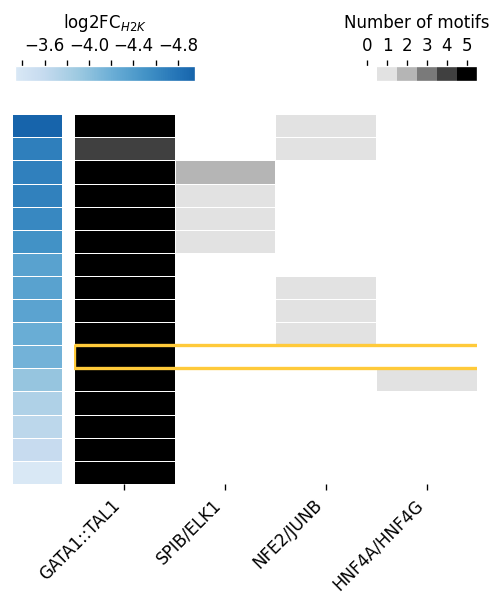

In [29]:

bluesBig = matplotlib.cm.get_cmap('Blues', 512)
blues_trunc_cm = matplotlib.colors.ListedColormap(bluesBig(np.linspace(0.15, 0.8, 256)))
# create reverse version of blues_trunc_cm
blues_trunc_cm_r = matplotlib.colors.ListedColormap(bluesBig(np.linspace(0.8, 0.15, 256)))

orangesBig = matplotlib.cm.get_cmap('Oranges', 512)
oranges_trunc_cm = matplotlib.colors.ListedColormap(orangesBig(np.linspace(0.15, 0.8, 256)))

h2k_cmap_dict = {'HEPG2': oranges_trunc_cm,'K562': blues_trunc_cm_r}

# create new numpy array that's n_seqs x n_clusters
clusters = np.array([col for col in d3_deseq_plus_cluster_cnts_df.columns if col.startswith('cluster_')])
print(f'{len(clusters)} clusters')

# HEPG2: 433, 905, 335, 667, 633
# K562: 156, 762, 1041, 976, 1099
cur_seq_idx = 156
cur_analysis_df = analysis_df[analysis_df['og_seq_idx']==cur_seq_idx].copy()
cur_cell_type = cur_analysis_df['cell_type'].values[0]
cur_analysis_df = cur_analysis_df.sort_values(by=H2K_COL,ascending=(cur_cell_type=='K562'))
# reset index
cur_analysis_df.reset_index(inplace=True,drop=True)
# drop all cluster columns that sum to 0

cluster_cols = [col for col in cur_analysis_df.columns if 'cluster_' in col]
cur_analysis_df.drop(columns=[col for col in cluster_cols if cur_analysis_df[col].sum()==0], inplace=True)
cluster_cols = np.array([col for col in cur_analysis_df.columns if 'cluster_' in col])
print(len(cluster_cols))

## here##########################################################################################

vmin = cur_analysis_df[cluster_cols].min().min()
vmax = cur_analysis_df[cluster_cols].max().max()
# vmax = 3

# make the cmap for heatmap
n_colors = int(vmax-vmin+1)
colors = plt.cm.Greys(np.linspace(0, 1, n_colors))
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_colors)

# plot np.array(cur_analysis_df[hepg2_clusters]) as heatmap with rows corresponding to sequences and columns the motifs
n_clusters_to_plot = 8
cluster_sort_inds = np.argsort(np.array(cur_analysis_df[cluster_cols]).sum(axis=0))[::-1][:n_clusters_to_plot]


# set figure width based on number of clusters, using a constant width_per_cluster
width_per_cluster = 5
fig_width = width_per_cluster * n_clusters_to_plot

# 4 hepg2 motifs, 5 k562 motifs so axis ratios should be 4:5
# 8 HEPG2 motifs, 5 K562 motifs so axis ratios should be 8:5
# fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4,figsize=(8,2),sharey=True,gridspec_kw={'width_ratios': [1,8,1,10]})

# make 2 side by side subplots
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(5,4),sharey=True,gridspec_kw={'width_ratios': [1, 8]})
# plot hepg2 heatmap
sns.heatmap(np.array(cur_analysis_df[cluster_cols])[:,cluster_sort_inds],xticklabels=cluster_cols[cluster_sort_inds],cmap=cmap,cbar=False,ax=ax1,
            edgecolor='white',linewidth=0.5)
# remove yticks
ax1.set_yticks([])
# ax1.set_title(f'HEPG2')
ax1.set_xticklabels([cluster_name_dict[cluster] for cluster in cluster_cols[cluster_sort_inds]],fontsize=TEXT_FSIZE,rotation=45,ha='right')
# plot hepg2 log2(H2K):
sns.heatmap(cur_analysis_df[H2K_COL].values.reshape(-1, 1), cmap=h2k_cmap_dict[cur_cell_type], cbar=False, ax=ax0,annot=False,
            fmt='.1f',edgecolor='white',linewidth=0.5) #,vmin=h2k_vmin,vmax=h2k_vmax


# set overall figure title
# fig.suptitle(f'Motifs in top {int(percentile*100)}% of sequences\n')

# add colorbar below the subplots
# cbar_ax = fig.add_axes([0.3, -0.175, 0.4, 0.03])
from matplotlib.ticker import MaxNLocator
cbar_ax = fig.add_axes([0.7, 0.95, 0.2, 0.03])

boundaries = np.linspace(vmin - 0.5, vmax + 0.5, n_colors + 1)
ticks = np.arange(vmin, vmax + 1)

cb = fig.colorbar(ax1.collections[0], cax=cbar_ax,orientation='horizontal',label='Number of motifs',shrink=0.01,drawedges=False,boundaries=boundaries,ticks=ticks,format="%d")
# plt.colorbar(ticks=ticks, boundaries=boundaries, format="%d", orientation='vertical')
# cb = fig.colorbar(ax1.collections[0], cax=cbar_ax,orientation='horizontal',label='Number of motifs',shrink=0.01,drawedges=False,boundaries=np.arange(0,vmax+1,1),ticks=np.arange(0,vmax+1,1))
cbar_ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cbar_ax.xaxis.tick_top()
# move title of cbar_ax to above the colorbar
cbar_ax.set_title('Number of motifs',fontsize=TEXT_FSIZE,y=3)
# remove x and y labels
cbar_ax.set_xlabel('')
cbar_ax.set_ylabel('')
# set cb outline to white
cb.outline.set_edgecolor('white')
# set cb ticks to ticks
cb.set_ticks(ticks=ticks,labels=np.arange(vmin,vmax+1).astype(int))

# add colorbar for H2K for HEPG2 seqs to the left of cbar_ax
cbar_ax_h2k = fig.add_axes([0.13, 0.95, 0.3, 0.03])
# cbar_ax_h2k = fig.add_axes([0.13, 0.95, 0.2, 0.03])
cb_hepg2 = fig.colorbar(ax0.collections[0], cax=cbar_ax_h2k,orientation='horizontal',label='log2(HEPG2/K562)',shrink=0.01,drawedges=False)
cbar_ax_h2k.xaxis.set_major_locator(MaxNLocator(integer=True))
# move ticks above colorbar
cbar_ax_h2k.xaxis.tick_top()
# move title of cbar_ax to above the colorbar
cbar_ax_h2k.set_title('log2FC$_{H2K}$',fontsize=TEXT_FSIZE,y=3)
# remove x and y labels
cbar_ax_h2k.set_xlabel('')
cbar_ax_h2k.set_ylabel('')
# set colorbar outline to white
cb_hepg2.outline.set_edgecolor('white')
# reverse the colorbar
if cur_cell_type == 'K562':
    cbar_ax_h2k.invert_xaxis()


# remove yticks from ax0
ax0.set_yticks([])
ax0.set_xticks([])
# decrease space between ax0 and ax1
plt.subplots_adjust(wspace=0.05)

# plot every other xtick label on cbar_ax_hepg2_h2k
for i,tick in enumerate(cbar_ax_h2k.get_xticklabels()):
    if i%2==0:
        tick.set_visible(False)

# put a solid black outline in ax1 around the row corresponding to the original sequence, i.e. had model_type == 'd2_meas'
# get index of row corresponding to original sequence
#import patches from matplotlib
import matplotlib.patches as patches
og_seq_pos = cur_analysis_df[cur_analysis_df['model_type']=='d2_meas'].index[0]
# plot a rectangle around this row
rect = patches.Rectangle((0,og_seq_pos),n_clusters_to_plot,1,linewidth=2,edgecolor='#FFCA3A',facecolor='none')
# Add the patch to the Axes
ax1.add_patch(rect)

# save figure
plt.savefig(f'{fig3_dir}/fig4_flank_opt_motif_heatmap_{cur_seq_idx}.png',dpi=600,bbox_inches='tight')

### Fig 3B-H: Motif ablation plots ###

In [3]:
analysis_df = d3_deseq_plus_cluster_cnts_df[d3_deseq_plus_cluster_cnts_df['design_type']=='ablated'].copy()

n_motifs_vec = []

# extract original sequence index from sequence name
analysis_df['og_seq_idx'] = analysis_df['sequence_name'].apply(lambda x: int(x.split('_')[0]))
# set og_seq_idx to int
analysis_df['og_seq_idx'] = analysis_df['og_seq_idx'].astype(int)
# extract unmodified sequence
for d2_seq_idx in analysis_df['og_seq_idx'].unique():
    if f'd2_seq_{d2_seq_idx:.0f}' in d3_deseq_plus_cluster_cnts_df['sequence_name'].values:
        # print(f'{d2_seq_idx:.0f} is in d3_seq_df')
        # append this row to analysis_df using pd.concat
        analysis_df = pd.concat([analysis_df,d3_deseq_plus_cluster_cnts_df[d3_deseq_plus_cluster_cnts_df['sequence_name']==f'd2_seq_{d2_seq_idx:.0f}']])
        # n_motifs_vec = n_motifs_vec + [d3_seq_df[d3_seq_df['sequence_name']==f'd2_seq_{d2_seq_idx:.0f}']['n_motifs'].values[0]]
    else:
        print(f'Error: {d2_seq_idx} is NOT in d3_seq_df')

# append d2 1041, which is actually d1 22263
analysis_df = pd.concat([analysis_df,d3_deseq_plus_cluster_cnts_df[d3_deseq_plus_cluster_cnts_df['sequence_name']==f'd1_seq_22263']])
analysis_df.loc[analysis_df['model_type']=='d2_meas','og_seq_idx'] = analysis_df.loc[analysis_df['model_type']=='d2_meas','sequence_name'].apply(lambda x: int(x.split('_')[2]))

# set og_seq_idx 22263 to 1041
analysis_df.loc[analysis_df['og_seq_idx']==22263,'og_seq_idx'] = 1041

Error: 1041 is NOT in d3_seq_df


In [31]:
analysis_df[analysis_df['model_type']=='d2_meas']['n_motifs'].median()

3.5

In [4]:
## Interlude! Let's simulate the double ablations on 1041 and 976 ###

# first, I need to generate the three random shuffles for this double ablation (per sequence)
# then, I need to load the finetuned ensemble model and predict the log2(HEPG2/K562) for each of these sequences
# finally, I will add these to the analysis_df dataframe with appropriate col info
# I might still need to figure out where I'm currently hardcoding a value of 1 for these double ablations, which might overwrite the sims

# okay, first up let's pull in the ablation code - only for double ablations
from deeplift.dinuc_shuffle import dinuc_shuffle
def generate_ablated_motif_seqs(motif_flank_buffer, seq_idx, cur_cell_type, cur_seq, cur_seq_motifs, motif_pairs, seq_df,n_vars):
    # do double motif ablations
    for motif_set_idx in range(len(motif_pairs)):
        for var_idx in range(n_vars):

            cur_seq_copy = cur_seq
            motifs = np.array(motif_pairs)[motif_set_idx]
            cur_motif_set = cur_seq_motifs.iloc[motifs]
            for motif_start, motif_end in zip(cur_motif_set['start'].values, cur_motif_set['stop'].values) :
                # replace motif with shuffled sequence - note here I'm shuffling the whole sequence and excerpting an appropriate length to replace the motif, this is a reasonable bg, shuffling only the motif would probably result in motif-like sequences too often
                cur_seq_copy = cur_seq_copy[:motif_start - motif_flank_buffer] + dinuc_shuffle(cur_seq)[motif_start - motif_flank_buffer:motif_end + motif_flank_buffer] + cur_seq_copy[motif_end + motif_flank_buffer:]

            powerset_suffix = ''.join([str(i) for i in motif_pairs[motif_set_idx]])
            seq_name = f'{seq_idx}_ablated_{powerset_suffix}_{var_idx}'
            seq_df = pd.concat([seq_df, pd.DataFrame([[seq_name, 'ablated', cur_cell_type,cur_seq_copy]], columns=['sequence_name','design_type','cell_type','sequence'])])
    return seq_df

def extract_nonmotif_from_seq(nonmotif_mask):
    nonmotif_intervals = []
    cur_interval = []
    for i in range(len(nonmotif_mask)) :
        if nonmotif_mask[i] == 1 :
            if len(cur_interval) == 0 :
                cur_interval.append(i)
        else :
            if len(cur_interval) > 0 :
                cur_interval.append(i)
                nonmotif_intervals.append(cur_interval)
                cur_interval = []
    return nonmotif_intervals

seq_df = pd.DataFrame()

motif_flank_buffer = 1
for seq_idx in [976,1041]:
    print(seq_idx)
    
    # seq_idx = d2_deseq_df.index[cur_idx]
    cur_cell_type = d2_deseq_df.iloc[seq_idx]['cell_type']

    cur_seq = d2_deseq_df.iloc[seq_idx]['enhancer']
    cur_seq_motifs = d2_final_df[d2_final_df['sequence_name'] == seq_idx]
    seq_len = len(cur_seq)
    # create mask with motif positions
    motif_mask = np.zeros(seq_len,dtype=int)
    for motif_start, motif_end in zip(cur_seq_motifs['start'].values, cur_seq_motifs['stop'].values) :
        motif_mask[motif_start - motif_flank_buffer:motif_end + motif_flank_buffer] = 1

    # get nonmotif_mask - this can be used as input to masked SeqProp for optimized/adversarial perturbations!
    nonmotif_mask = (1 - motif_mask)

    n_motifs = len(cur_seq_motifs)
    n_motifs_not_cluster27 = len(cur_seq_motifs[cur_seq_motifs['jaspar_cluster'] != 'cluster_27'])
    # get all pairs of motifs
    motif_pairs = list(itertools.combinations(range(n_motifs), 2))
    # for pair in motif_pairs :
    #     print(pair)
    print(n_motifs)



    # get all intervals of nonmotif_sequence
    nonmotif_intervals = extract_nonmotif_from_seq(nonmotif_mask)
    n_vars = 3
    seq_df = generate_ablated_motif_seqs(motif_flank_buffer, seq_idx, cur_cell_type, cur_seq, cur_seq_motifs, motif_pairs, seq_df,n_vars)

seq_df['og_seq_idx'] = seq_df['sequence_name'].apply(lambda x: int(x.split('_')[0]))

976
2
1041
2


In [5]:
# okay now I want to load model and predict log2(HEPG2/K562) for these sequences
model_dir = 'd2_finetuned/test_fold_0/d3_tot'
model_basename = 'd1_wide_ft_cf_t0_v'
model_suffix = '_d2_ft'

n_crossfolds = 1
n_models = 9

ensemble_inds = np.arange(1,1+n_models)
model = load_ensemble_model(model_dir,model_basename,ensemble_inds,model_suffix=model_suffix)

# one hot encode the seq_df seqs and pad to 200 bp
def seq_to_one_hot_and_pad(seq,pad_len,order_dict = {'A':0, 'T':3, 'C':1, 'G':2}):
    x = np.zeros((len(seq), 4))
    for (i, bp) in enumerate(seq):
        x[i, order_dict[bp]] = 1
    seq_len = len(seq)
    if seq_len < pad_len:
        lpad = (pad_len-seq_len)//2
        rpad = pad_len - seq_len - lpad
        x = np.pad(x,((lpad,rpad),(0,0)),'constant')
    return x

pad_len = 200
x = np.stack([seq_to_one_hot_and_pad(seq,pad_len) for seq in seq_df['sequence'].values])
y = model.predict(x)

seq_df[HEPG2_COL] = y[:,0]
seq_df[K562_COL] = y[:,1]
seq_df[H2K_COL] = y[:,0] - y[:,1]

# add seq_df to analysis_df
analysis_df = pd.concat([analysis_df,seq_df])



1/1 [==============================] - 1s 889ms/step


In [6]:
single_del_df_cols = ['og_seq_idx','cell_type','ablation_type','ablation_idx','motif_type','motif_pos','og_h2k','mean_delta_h2k','std_delta_h2k']
single_del_df = pd.DataFrame(columns=single_del_df_cols)

# for swarm plot I will just want to extract og_seq_idx, cell_type, ablation_type, mean_delta_h2k, std_delta_h2k, og_h2k? motif type?
# am = additive model
double_del_df_cols = ['og_seq_idx','cell_type','ablation_type','ablation_idx','motif_type_A','motif_type_B','motif_A_pos','motif_B_pos','og_h2k','mean_delta_h2k','std_delta_h2k','am_h2k','am_h2k_se']
double_del_df = pd.DataFrame(columns=double_del_df_cols)

for cur_seq_idx in analysis_df['og_seq_idx'].unique():   
    cur_analysis_df = analysis_df[analysis_df['og_seq_idx']==cur_seq_idx].copy()
    og_h2k = cur_analysis_df[cur_analysis_df['model_type']=='d2_meas'][H2K_COL].values[0]
    cell_type_factor = ((cur_analysis_df['cell_type'].values[0]=='HEPG2')-0.5)*2 # -1 for K562, +1 for HEPG2
    cur_analysis_df['delta_h2k'] = (og_h2k - cur_analysis_df[H2K_COL]) * cell_type_factor / np.abs(og_h2k)
    # cur_analysis_df.loc[cur_analysis_df['design_type']=='ablated','delta_h2k'] = og_h2k - cur_analysis_df.loc[cur_analysis_df['design_type']=='ablated',H2K_COL]
    cur_analysis_df.loc[cur_analysis_df['design_type']=='ablated','ablation_idx'] = cur_analysis_df.loc[cur_analysis_df['design_type']=='ablated','sequence_name'].apply(lambda x: x.split('_')[-2])
    # set ablation index type to str
    cur_analysis_df['ablation_idx'] = cur_analysis_df['ablation_idx'].astype(str)
    cur_seq_motifs = d2_final_df[d2_final_df['sequence_name']==cur_seq_idx].copy()
    motif_names = [f'{x}_{y}' for x,y in cur_seq_motifs[['motif_alt_id','start']].values]
    print(motif_names)
    single_dels = cur_analysis_df[cur_analysis_df['ablation_idx'].apply(len)==1].copy()
    double_dels = cur_analysis_df[cur_analysis_df['ablation_idx'].apply(len)==2].copy()

    if cur_seq_idx in [976,1041]:
        # add a row to double_dels with ablation_idx = '01' and delta_h2k = 1
        double_dels = pd.concat([double_dels,pd.DataFrame({'ablation_idx':['01'],'delta_h2k':[1],'og_seq_idx':[cur_seq_idx]})])

    single_dels['motif_idx'] = single_dels['ablation_idx'].apply(lambda x: motif_names[int(x)])
    double_dels['motif_idx'] = double_dels['ablation_idx'].apply(lambda x: motif_names[int(x[0])] + ', ' + motif_names[int(x[1])])

    # get mean delta_h2k grouped by ablation_idx
    # Single ablations
    single_dels_agg = single_dels.groupby('ablation_idx').agg({'delta_h2k':['mean','std','count']})

    # for each ablation_index in single_dels_agg, add row to single_del_df
    for ablation_idx in single_dels_agg.index:
        cur_ablation_df = pd.DataFrame(columns=single_del_df_cols,index=[0])
        cur_ablation_df['og_seq_idx'] = cur_seq_idx
        cur_ablation_df['cell_type'] = analysis_df.loc[analysis_df['og_seq_idx']==cur_seq_idx,'cell_type'].values[0]
        cur_ablation_df['ablation_type'] = 'single'
        cur_ablation_df['ablation_idx'] = ablation_idx
        motif_idx = single_dels.loc[single_dels['ablation_idx']==ablation_idx]['motif_idx'].values[0]
        cur_ablation_df['motif_type'] = motif_idx.split('_')[0]
        cur_ablation_df['motif_pos'] = int(motif_idx.split('_')[1])
        cur_ablation_df['og_h2k'] = og_h2k
        cur_ablation_df['mean_delta_h2k'] = single_dels_agg.iloc[int(ablation_idx)]['delta_h2k']['mean']
        cur_ablation_df['std_delta_h2k'] = single_dels_agg.iloc[int(ablation_idx)]['delta_h2k']['std']
        # cur_ablation_df['norm_delta_h2k'] = cur_ablation_df['log2(H2K)_pred_norm']
        # # drop all columns except og_seq_idx, cell_type, ablation_type, ablation_idx, shuffle_idx, motif_idx, og_h2k, mean_delta_h2k, std_delta_h2k, norm_delta_h2k
        cur_ablation_df.drop(columns=[col for col in cur_ablation_df.columns if col not in single_del_df.columns],inplace=True)
        single_del_df = pd.concat([single_del_df,cur_ablation_df])

    # Double ablations
    double_dels_agg = double_dels.groupby('ablation_idx').agg({'delta_h2k':['mean','std','count']})
    n_samples = 3 # for se propagation...maybe set to 1? Or else I should use se for single dels too, not sd...

    # # for the 2 K562 seqs with 2 motifs (so only single ablations, no doubles), estimate double ablation score as 1
    # if cur_seq_idx in [976,1041]:
    #     double_dels_agg.loc['01','delta_h2k'] = {'mean':1,'std':0,'count':1}

    for ablation_idx in double_dels_agg.index:
        cur_ablation_df = pd.DataFrame(columns=double_del_df_cols,index=[0])
        cur_ablation_df['og_seq_idx'] = cur_seq_idx
        cur_ablation_df['cell_type'] = analysis_df.loc[analysis_df['og_seq_idx']==cur_seq_idx,'cell_type'].values[0]
        cur_ablation_df['ablation_type'] = 'double'
        cur_ablation_df['ablation_idx'] = ablation_idx
        motif_idx = double_dels.loc[double_dels['ablation_idx']==ablation_idx]['motif_idx'].values[0]
        motif_idx_A,motif_idx_B = motif_idx.split(', ')
        cur_ablation_df['motif_type_A'] = motif_idx_A.split('_')[0]
        cur_ablation_df['motif_type_B'] = motif_idx_B.split('_')[0]
        cur_ablation_df['motif_A_pos'] = int(motif_idx_A.split('_')[1])
        cur_ablation_df['motif_B_pos'] = int(motif_idx_B.split('_')[1])
        cur_ablation_df['og_h2k'] = og_h2k
        cur_ablation_df['mean_delta_h2k'] = double_dels_agg.loc[ablation_idx,'delta_h2k']['mean']
        cur_ablation_df['std_delta_h2k'] = double_dels_agg.loc[ablation_idx,'delta_h2k']['std']
        cur_ablation_df['am_h2k'] = single_dels_agg.loc[ablation_idx[0],'delta_h2k']['mean'] + single_dels_agg.loc[ablation_idx[1],'delta_h2k']['mean']
        # woah this is so smart, good job copilot and also me for having a good idx scheme
        cur_ablation_df['am_h2k_se'] = np.sqrt((single_dels_agg.loc[ablation_idx[0],'delta_h2k']['std']/np.sqrt(n_samples))**2 + \
            (single_dels_agg.loc[ablation_idx[1],'delta_h2k']['std']/np.sqrt(n_samples))**2)
        # drop all columns not in double_del_df_cols
        cur_ablation_df.drop(columns=[col for col in cur_ablation_df.columns if col not in double_del_df.columns],inplace=True)
        double_del_df = pd.concat([double_del_df,cur_ablation_df])



# okay but I also want to add in (I think) the 976 and 1041 rows with estimated double ablation scores of 1
# so I need to add in these rows to double_del_df
# first create a new dataframe with these rows
# extra_double_del_df = pd.DataFrame(columns=double_del_df_cols,index=[0,1])
# extra_double_del_df['og_seq_idx'] = [976,1041]
# extra_double_del_df['cell_type'] = 'K562'
# extra_double_del_df['ablation_type'] = 'double'
# extra_double_del_df['ablation_idx'] = '01' # only 2 motifs in these seqs
# extra_double_del_df['motif_type_A'] = 'MAFK'

single_del_df.reset_index(inplace=True,drop=True)
# annotate with jaspar cluster
for idx,row in single_del_df.iterrows():
    og_seq_idx,motif_alt_id,start = row['og_seq_idx'],row['motif_type'],row['motif_pos']
    # print(og_seq_idx,motif_alt_id,start)
    cluster = d2_final_df.loc[(d2_final_df['sequence_name']==og_seq_idx) & (d2_final_df['motif_alt_id']==motif_alt_id) & (d2_final_df['start']==start),'jaspar_cluster'].values[0]
    score = d2_final_df.loc[(d2_final_df['sequence_name']==og_seq_idx) & (d2_final_df['motif_alt_id']==motif_alt_id) & (d2_final_df['start']==start),'score'].values[0]
    # add cluster value to single_del_df
    single_del_df.loc[idx,'jaspar_cluster'] = cluster
    single_del_df.loc[idx,'fimo_match_score'] = score

double_del_df.reset_index(inplace=True,drop=True)
# annotate with jaspar cluster
for idx,row in double_del_df.iterrows():
    og_seq_idx,motif_alt_id_A,start_A,motif_alt_id_B,start_B = row['og_seq_idx'],row['motif_type_A'],row['motif_A_pos'],row['motif_type_B'],row['motif_B_pos']
    # print(og_seq_idx,motif_alt_id,start)
    cluster_A = d2_final_df.loc[(d2_final_df['sequence_name']==og_seq_idx) & (d2_final_df['motif_alt_id']==motif_alt_id_A) & (d2_final_df['start']==start_A),'jaspar_cluster'].values[0]
    cluster_B = d2_final_df.loc[(d2_final_df['sequence_name']==og_seq_idx) & (d2_final_df['motif_alt_id']==motif_alt_id_B) & (d2_final_df['start']==start_B),'jaspar_cluster'].values[0]
    # add cluster value to single_del_df
    double_del_df.loc[idx,'jaspar_cluster_A'] = cluster_A
    double_del_df.loc[idx,'jaspar_cluster_B'] = cluster_B

['TP53_38', 'HNF4A_59', 'TP53_120']
['TP53_4', 'TP53_20', 'HNF4A_88', 'TP53_108', 'HNF4G_126']
['TP53_30', 'TP53_70', 'TP53_110']
['TP53_6', 'TP53_54', 'TP53_126']
['ZNF816_24', 'TP53_65', 'TP53_89', 'HNF4A_112']
['BNC2_47', 'GATA1::TAL1_80']
['GATA1::TAL1_49', 'BNC2_88']
['ELF3_16', 'PATZ1_37', 'FOSL1::JUN_77', 'GATA2_111', 'KLF15_134']
['GATA1::TAL1_2', 'GATA1::TAL1_27', 'GATA1::TAL1_53', 'GATA1::TAL1_95', 'EGR1_112', 'GATA1::TAL1_126']
['ZNF148_10', 'ELF5_21', 'STAT4_33', 'USF1_67', 'GATA1::TAL1_78', 'ZBTB7A_110', 'FOS_126']


C:\Users\Chris\AppData\Local\Temp\ipykernel_25036\2170012053.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  single_del_df = pd.concat([single_del_df,cur_ablation_df])
C:\Users\Chris\AppData\Local\Temp\ipykernel_25036\2170012053.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  double_del_df = pd.concat([double_del_df,cur_ablation_df])


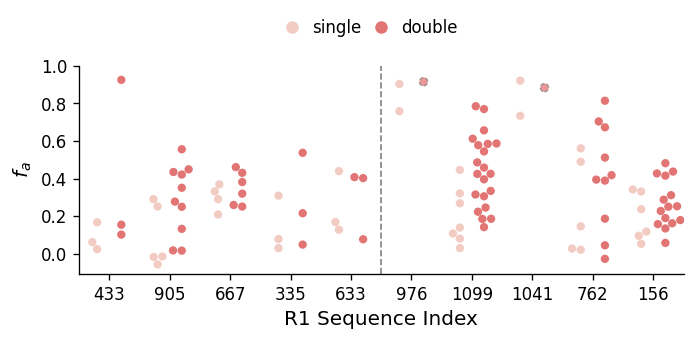

In [33]:
# swarm plot of double and single ablations

# for swarm plot I will just want to extract og_seq_idx, cell_type, ablation_type, mean_delta_h2k, std_delta_h2k, og_h2k? motif type?

merge_cols = ['og_seq_idx','cell_type','ablation_type','ablation_idx','mean_delta_h2k','std_delta_h2k','og_h2k']
merged_ablation_df = pd.concat([single_del_df[merge_cols],double_del_df[merge_cols]])
# reset index
merged_ablation_df.reset_index(inplace=True,drop=True)
# set og_seq_idx to int
merged_ablation_df['og_seq_idx'] = merged_ablation_df['og_seq_idx'].astype(int)

sort_inds = merged_ablation_df.groupby('og_seq_idx')['og_h2k'].mean().sort_values(ascending=False).index
# reverse the order of the second half of the sort_inds
sort_inds = np.concatenate([sort_inds[:len(sort_inds)//2],sort_inds[len(sort_inds)//2:][::-1]])


# swarm plot where x axis is og_seq_idx, y axis is mean_delta_h2k, hue is ablation_type, style is cell_type
# set hue_order to single, double
hue_order = ['single','double']
# ablation_palette = {'single':'#F2CCC3','double':'#E78F8E'}
ablation_palette = {'single':'#F2CCC3','double':'#e27574ff'}

# reset index
merged_ablation_df.reset_index(inplace=True,drop=True)
# plot swarmplot
plt.figure(figsize=(6.5,2.25))
sns.swarmplot(x='og_seq_idx',y='mean_delta_h2k',data=merged_ablation_df,hue='ablation_type',order=sort_inds,hue_order=hue_order,
              palette=ablation_palette,size=5,edgecolor='k',linewidth=0.0,dodge=True,)
# place legend outside of plot
# set legend labels to 'Single', 'Double', with large marker size
# plt.legend(loc='upper left',bbox_to_anchor=(1.01,1.01),fontsize=TEXT_FSIZE,markerscale=2)
# plot legend centered at top of plot
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),frameon=False,fontsize=TEXT_FSIZE,markerscale=2)
# move legend to bottom left of plot, 1 row
plt.xlabel('R1 Sequence Index',fontsize=AXIS_FSIZE)
plt.ylabel('$f_a$',fontsize=AXIS_FSIZE)
sns.despine()
# draw vertical line at 4.5
plt.axvline(x=4.5,color='k',linewidth=1,linestyle='--',alpha=0.5)

# set yticks 0 to 1
plt.yticks(np.arange(0,1.1,0.2),fontsize=TEXT_FSIZE)

# center legend at top of plot
plt.legend(loc='upper center', bbox_to_anchor=(0.475, 1.3),frameon=False,fontsize=TEXT_FSIZE,markerscale=1.5,ncol=2,handletextpad=0.2,columnspacing=0.2)
# plt.legend(loc='upper left', bbox_to_anchor=(0.15, 1.4),frameon=False,fontsize=TEXT_FSIZE,title_fontsize=TEXT_FSIZE,
#            labels=['Single','Double'],title='Ablation Type',markerscale=2,ncol=2,handletextpad=0.25,columnspacing=0.5)

# for double points in 976 and 1041, add dashed outline
# get indices of 976 and 1041

# plot dashed outline around these points
for ind in [11,15]:
    plt.gca().get_children()[ind].set_edgecolor('gray')
    plt.gca().get_children()[ind].set_linestyle('--')
    plt.gca().get_children()[ind].set_linewidth(0.75)
    plt.gca().get_children()[ind].set_alpha(0.75)

# save figure
# plt.savefig(f'{fig3_dir}/fig4_ablation_swarm.svg',format='svg',bbox_inches='tight')
plt.savefig(f'{fig3_dir}/fig4_ablation_swarm.png',dpi=600,bbox_inches='tight')

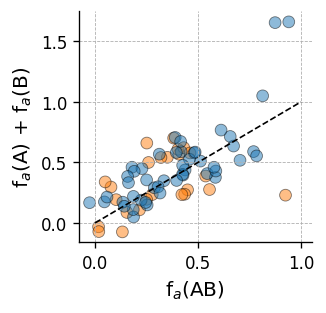

In [38]:
# for double_del_df, plot scatterplot of additive model vs double ablation meas

cell_type_palette = {'HEPG2':'tab:orange','K562':'tab:blue'}

# plot scatterplot of additive model vs double ablation meas
plt.figure(figsize=(2.5,2.5))
sns.scatterplot(x='mean_delta_h2k',y='am_h2k',data=double_del_df,edgecolor='k',linewidth=0.5,s=50,alpha=0.5,hue='cell_type',palette=cell_type_palette)
# plot diagonal line
plt.plot([0,1],[0,1],color='k',linewidth=1,linestyle='--')
plt.xlabel('f$_a$(AB)',fontsize=AXIS_FSIZE)
plt.ylabel('f$_a$(A) + f$_a$(B)',fontsize=AXIS_FSIZE)

# # set xlim and ylim from -0.5 to 1.5
# plt.xlim(-0.1,1.5)
# plt.ylim(-0.1,1.5)

# gridlines
plt.grid(True,which='both',ls='--',lw=0.5)

sns.despine()
# hide legend
plt.legend().remove()

# save figure
plt.savefig(f'{fig3_dir}/fig4_double_ablation_scatter.png',dpi=600,bbox_inches='tight')

0.02474341283014771
0.16741394093574433
0.06178389580947782


(array([0.5, 1.5, 2.5]),
 [Text(0.5, 0, 'TP53_120'),
  Text(1.5, 0, 'HNF4A/HNF4G_59'),
  Text(2.5, 0, 'TP53_38')])

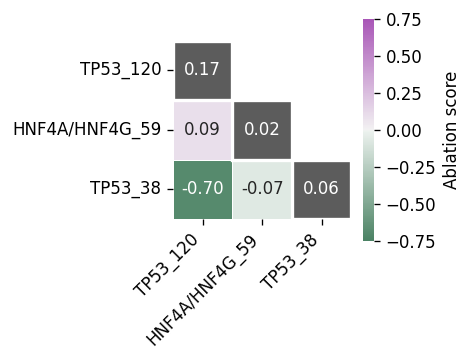

In [29]:
### Plot linear deviation map for a chosen sequence ###

# import Rectangle
from matplotlib.patches import Rectangle

### Plot ablation map for a chosen sequence ###

cur_seq_idx = 433


cur_ablation_df = double_del_df[double_del_df['og_seq_idx']==cur_seq_idx].copy()
cur_ablation_df['dev_score'] = cur_ablation_df['am_h2k'] - cur_ablation_df['mean_delta_h2k']

# heatmap of mean_delta_h2k for each double ablation, with motif A on y axis and motif B on x axis
cur_ablation_df['motif_A_name'] = cur_ablation_df['motif_type_A'] + '_' + cur_ablation_df['motif_A_pos'].astype(str)
cur_ablation_df['motif_B_name'] = cur_ablation_df['motif_type_B'] + '_' + cur_ablation_df['motif_B_pos'].astype(str)
cluster_A_name = cur_ablation_df['jaspar_cluster_A'].apply(lambda x: cluster_name_dict[x] if x in cluster_name_dict else x)
cluster_B_name = cur_ablation_df['jaspar_cluster_B'].apply(lambda x: cluster_name_dict[x] if x in cluster_name_dict else x)
cur_ablation_df['cluster_A_name'] = cluster_A_name + '_' + cur_ablation_df['motif_A_pos'].astype(str)
cur_ablation_df['cluster_B_name'] = cluster_B_name + '_' + cur_ablation_df['motif_B_pos'].astype(str)

# add a row to cur_ablation_df for each individual motif with the single_del score
# get list of unique motif_names
motif_names = np.unique(np.concatenate((cur_ablation_df['motif_A_name'].unique(),cur_ablation_df['motif_B_name'].unique())))
for motif_name in motif_names:
    motif_pos = motif_name.split('_')[1]
    cluster = single_del_df.loc[(single_del_df['og_seq_idx']==cur_seq_idx) & (single_del_df['motif_type']==motif_name.split('_')[0]) & (single_del_df['motif_pos']==int(motif_name.split('_')[1])),'jaspar_cluster'].values[0]
    cluster_name = f'{cluster_name_dict[cluster]}_{motif_pos}'
    single_del_score = single_del_df.loc[(single_del_df['og_seq_idx']==cur_seq_idx) & (single_del_df['motif_type']==motif_name.split('_')[0]) & (single_del_df['motif_pos']==int(motif_name.split('_')[1])),'mean_delta_h2k'].values[0]
    print(single_del_score)
    # pretend that the mean_delta_h2k is dev_score just for plotting purposes
    cur_ablation_df = pd.concat([cur_ablation_df,pd.DataFrame({'motif_A_name':motif_name,'motif_B_name':motif_name,'dev_score':single_del_score,'cluster_A_name':cluster_name,'cluster_B_name':cluster_name},index=[0])])

# pivot table
# cur_ablation_df_pivot = cur_ablation_df.pivot(index='motif_A_name',columns='motif_B_name',values='dev_score')
cur_ablation_df_pivot = cur_ablation_df.pivot(index='cluster_A_name',columns='cluster_B_name',values='dev_score')
# sort to be lower triangle
# sort cur_ablation_df_pivot so rows and columns are in same order
# define sort_inds by motif_type_A position
pos_vec = [int(motif_name.split('_')[-1]) for motif_name in cur_ablation_df_pivot.columns]
# get sort_inds of pos_vec ascending
sort_inds = np.argsort(pos_vec)[::-1]
# sort cur_ablation_df_pivot
cur_ablation_df_pivot = cur_ablation_df_pivot.iloc[sort_inds,sort_inds]

# plot heatmap
n_motifs = cur_ablation_df_pivot.shape[0]
cell_width = 4/5
fig_width = n_motifs*cell_width
fig_height = n_motifs*cell_width

plt.figure(figsize=(fig_width,fig_height))

div_cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)
# plot heatmap with square aspect ratio
sns.heatmap(cur_ablation_df_pivot,cmap=div_cmap,annot=True,fmt='.2f',annot_kws={'fontsize':TEXT_FSIZE},
            linewidths=0.5,linecolor='white',cbar_kws={'label':'Ablation score'},square=True,
            vmin=-.75,vmax=.75,cbar=True)


# outline diagonal in ablation_palette['single']
# import Rectangle from matplotlib
# from matplotlib.patches import Rectangle
# for i in range(cur_ablation_df_pivot.shape[0]):
#     plt.gca().add_patch(Rectangle((i,i),1,1,linewidth=1,edgecolor='k',facecolor='none'))

# # plot white squares over everything but the diagonal
# for i in range(cur_ablation_df_pivot.shape[0]):
#     for j in range(cur_ablation_df_pivot.shape[1]):
#         if i!=j:
#             plt.gca().add_patch(Rectangle((j,i),1,1,linewidth=2,edgecolor='white',facecolor='white'))

# plot white squares over the diagonal
for i in range(cur_ablation_df_pivot.shape[0]):
    plt.gca().add_patch(Rectangle((i,i),1,1,linewidth=2,edgecolor='white',facecolor=sns.color_palette("Grays")[-2]))

# extract the text from each diagonal cell
# import Text from matplotlib
from matplotlib.text import Text
texts = [cell.get_text() for cell in plt.gca().get_children() if isinstance(cell,Text) and cell.get_text()!='']

diag_texts_dict = {
    762: ['0.56','0.15','0.49','0.02','0.03'],
    976: ['0.90','0.76'],
    433: ['0.17','0.02','0.06']
}
diag_texts = diag_texts_dict[cur_seq_idx]

# set text color to white for diagonal cells
for idx,cell in enumerate(plt.gca().get_children()):
    if isinstance(cell,Text) and cell.get_text()!='':
        if cell.get_text() in diag_texts:
            cell.set_color('white')


plt.xlabel('')
plt.ylabel('')
# plt.title(f'R1 Seq {cur_seq_idx} Ablations')
plt.title('')
# rotate xticks 45 degrees
plt.xticks(rotation=45,ha='right')

# save figure
# plt.savefig(f'{figure_dir}/fig4_lindev_map_{cur_seq_idx}.png',dpi=600,bbox_inches='tight',transparent=True)
# plt.savefig(f'{supp_fig_dir}/S5/cluster_heatmap_{cur_seq_idx}.png',dpi=600,bbox_inches='tight')

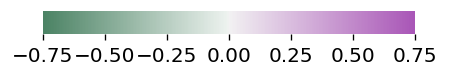

In [280]:
# create colorbar from div_cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True) with vmin=-.75,vmax=.75, horizontal

# create colorbar
fig, ax = plt.subplots(figsize=(4,0.25))
cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)
norm = plt.Normalize(-.75,.75)

cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,norm=norm,orientation='horizontal')
cb1.set_label('')
# remove black edges
cb1.outline.set_edgecolor('none')
# set xticks to -.75 to .75 by .25
cb1.set_ticks(np.arange(-.75,.76,.25))
# move xticks above colorbar
cb1.ax.xaxis.set_ticks_position('bottom')
# set tick fontsize
cb1.ax.tick_params(labelsize=12)
# save figure
plt.savefig(f'{figure_dir}/fig4_lindev_map_colorbar.png',dpi=600,bbox_inches='tight',transparent=True)

-0.05681083690184482
0.2515647401654549
0.2906056907100758
-0.014729101836894671
-0.017171007042774033
0.20890128040806152
0.36935075150947744
0.3315891294893637
0.2904715528781458
0.3091170024664331
0.07818549219127034
0.029778512528578476
0.4398745529444026
0.12785175868857754
0.1684669818572385
0.029866786197957285
0.13905576256340849
0.4460211634992675
0.2684425589594479
0.3210059941006685
0.1078122773959599
0.08019506768708358
0.7341328228923748
0.9209582729588618
0.09561877259065749
0.05305267439064179
0.34201595019769854
0.3309382110362441
0.23706504974655263
0.11818307911325789


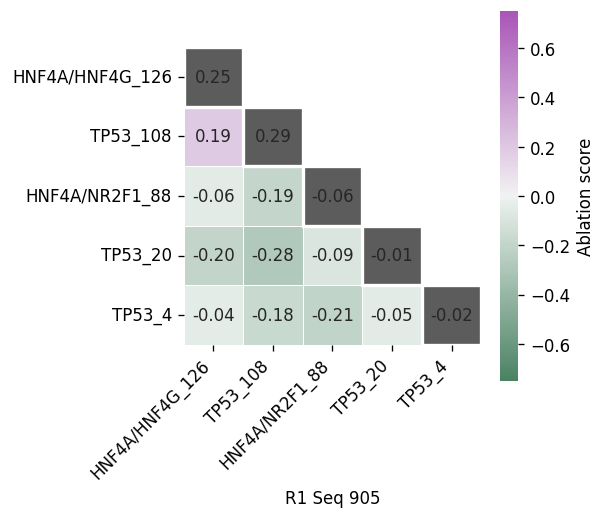

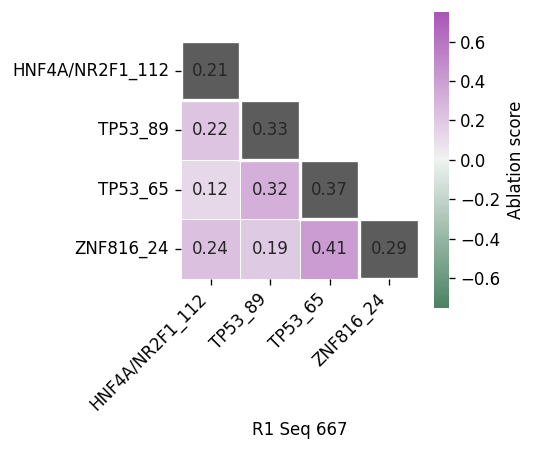

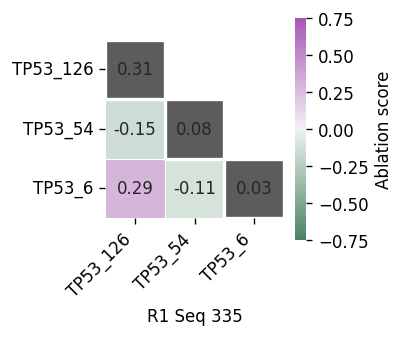

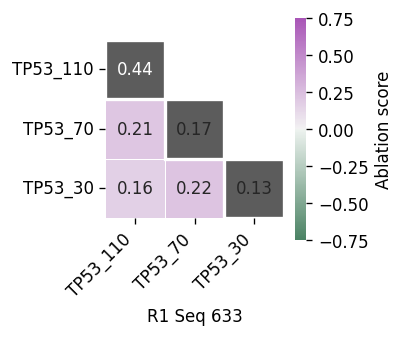

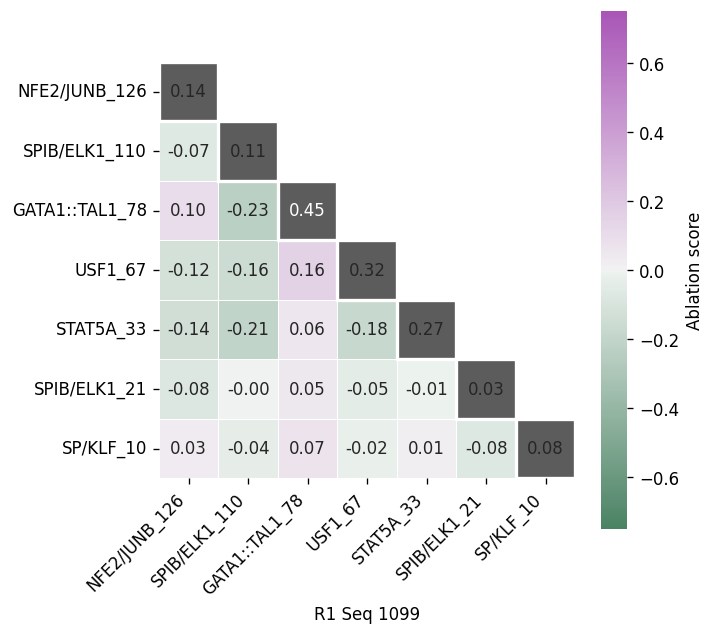

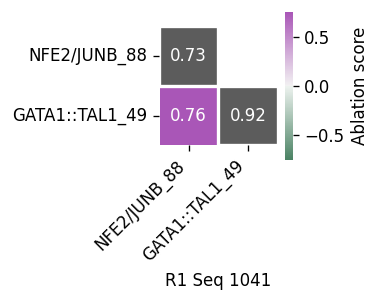

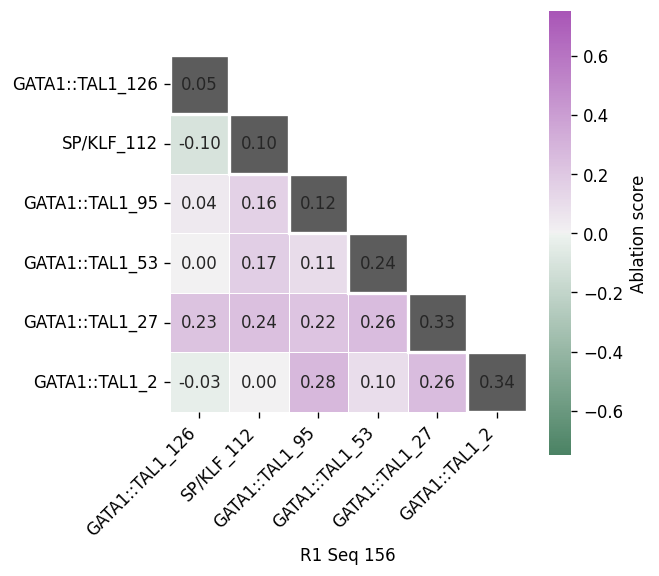

In [32]:
### Plot linear deviation map for a chosen sequence ###

# import Rectangle
from matplotlib.patches import Rectangle

### Plot ablation map for a chosen sequence ###

for cur_seq_idx in [905,667,335,633,1099,1041,156]:

    cur_ablation_df = double_del_df[double_del_df['og_seq_idx']==cur_seq_idx].copy()
    cur_ablation_df['dev_score'] = cur_ablation_df['am_h2k'] - cur_ablation_df['mean_delta_h2k']

    # heatmap of mean_delta_h2k for each double ablation, with motif A on y axis and motif B on x axis
    cur_ablation_df['motif_A_name'] = cur_ablation_df['motif_type_A'] + '_' + cur_ablation_df['motif_A_pos'].astype(str)
    cur_ablation_df['motif_B_name'] = cur_ablation_df['motif_type_B'] + '_' + cur_ablation_df['motif_B_pos'].astype(str)
    cluster_A_name = cur_ablation_df['jaspar_cluster_A'].apply(lambda x: cluster_name_dict[x] if x in cluster_name_dict else x)
    cluster_B_name = cur_ablation_df['jaspar_cluster_B'].apply(lambda x: cluster_name_dict[x] if x in cluster_name_dict else x)
    cur_ablation_df['cluster_A_name'] = cluster_A_name + '_' + cur_ablation_df['motif_A_pos'].astype(str)
    cur_ablation_df['cluster_B_name'] = cluster_B_name + '_' + cur_ablation_df['motif_B_pos'].astype(str)

    # add a row to cur_ablation_df for each individual motif with the single_del score
    # get list of unique motif_names
    motif_names = np.unique(np.concatenate((cur_ablation_df['motif_A_name'].unique(),cur_ablation_df['motif_B_name'].unique())))
    for motif_name in motif_names:
        motif_pos = motif_name.split('_')[1]
        cluster = single_del_df.loc[(single_del_df['og_seq_idx']==cur_seq_idx) & (single_del_df['motif_type']==motif_name.split('_')[0]) & (single_del_df['motif_pos']==int(motif_name.split('_')[1])),'jaspar_cluster'].values[0]
        cluster_name = f'{cluster_name_dict[cluster]}_{motif_pos}'
        single_del_score = single_del_df.loc[(single_del_df['og_seq_idx']==cur_seq_idx) & (single_del_df['motif_type']==motif_name.split('_')[0]) & (single_del_df['motif_pos']==int(motif_name.split('_')[1])),'mean_delta_h2k'].values[0]
        print(single_del_score)
        # pretend that the mean_delta_h2k is dev_score just for plotting purposes
        cur_ablation_df = pd.concat([cur_ablation_df,pd.DataFrame({'motif_A_name':motif_name,'motif_B_name':motif_name,'dev_score':single_del_score,'cluster_A_name':cluster_name,'cluster_B_name':cluster_name},index=[0])])

    # pivot table
    # cur_ablation_df_pivot = cur_ablation_df.pivot(index='motif_A_name',columns='motif_B_name',values='dev_score')
    cur_ablation_df_pivot = cur_ablation_df.pivot(index='cluster_A_name',columns='cluster_B_name',values='dev_score')
    # sort to be lower triangle
    # sort cur_ablation_df_pivot so rows and columns are in same order
    # define sort_inds by motif_type_A position
    pos_vec = [int(motif_name.split('_')[-1]) for motif_name in cur_ablation_df_pivot.columns]
    # get sort_inds of pos_vec ascending
    sort_inds = np.argsort(pos_vec)[::-1]
    # sort cur_ablation_df_pivot
    cur_ablation_df_pivot = cur_ablation_df_pivot.iloc[sort_inds,sort_inds]

    # plot heatmap
    n_motifs = cur_ablation_df_pivot.shape[0]
    cell_width = 4/5
    fig_width = n_motifs*cell_width
    fig_height = n_motifs*cell_width

    plt.figure(figsize=(fig_width,fig_height))

    div_cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)
    # plot heatmap with square aspect ratio
    sns.heatmap(cur_ablation_df_pivot,cmap=div_cmap,annot=True,fmt='.2f',annot_kws={'fontsize':TEXT_FSIZE},
                linewidths=0.5,linecolor='white',cbar_kws={'label':'Ablation score'},square=True,
                vmin=-.75,vmax=.75,cbar=True)


    # outline diagonal in ablation_palette['single']
    # import Rectangle from matplotlib
    # from matplotlib.patches import Rectangle
    # for i in range(cur_ablation_df_pivot.shape[0]):
    #     plt.gca().add_patch(Rectangle((i,i),1,1,linewidth=1,edgecolor='k',facecolor='none'))

    # # plot white squares over everything but the diagonal
    # for i in range(cur_ablation_df_pivot.shape[0]):
    #     for j in range(cur_ablation_df_pivot.shape[1]):
    #         if i!=j:
    #             plt.gca().add_patch(Rectangle((j,i),1,1,linewidth=2,edgecolor='white',facecolor='white'))

    # plot white squares over the diagonal
    for i in range(cur_ablation_df_pivot.shape[0]):
        plt.gca().add_patch(Rectangle((i,i),1,1,linewidth=2,edgecolor='white',facecolor=sns.color_palette("Grays")[-2]))

    # extract the text from each diagonal cell
    # import Text from matplotlib
    from matplotlib.text import Text
    texts = [cell.get_text() for cell in plt.gca().get_children() if isinstance(cell,Text) and cell.get_text()!='']

    # diag_texts_dict = {
    #     762: ['0.56','0.15','0.49','0.02','0.03'],
    #     976: ['0.90','0.76'],
    #     433: ['0.17','0.02','0.06']
    # }
    # diag_texts = diag_texts_dict[cur_seq_idx]

    # # set text color to white for diagonal cells
    # for idx,cell in enumerate(plt.gca().get_children()):
    #     if isinstance(cell,Text) and cell.get_text()!='':
    #         if cell.get_text() in diag_texts:
    #             cell.set_color('white')


    # set xlabel to cur_seq_idx
    plt.xlabel(f'R1 Seq {cur_seq_idx}')

    plt.ylabel('')
    # plt.title(f'R1 Seq {cur_seq_idx} Ablations')
    plt.title('')
    # rotate xticks 45 degrees
    plt.xticks(rotation=45,ha='right')

    # save figure
    # plt.savefig(f'{figure_dir}/fig4_lindev_map_{cur_seq_idx}.png',dpi=600,bbox_inches='tight',transparent=True)
    plt.savefig(f'{supp_fig_dir}/S4/lindev_map_{cur_seq_idx}.png',dpi=600,bbox_inches='tight',transparent=True)

C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  k, _ = kurtosistest(a, axis)


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.880
Model:                            WLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     80.56
Date:                Mon, 19 Feb 2024   Prob (F-statistic):           2.15e-06
Time:                        16:34:48   Log-Likelihood:                 15.078
No. Observations:                  13   AIC:                            -26.16
Df Residuals:                      11   BIC:                            -25.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0276      0.016     -1.714      0.1

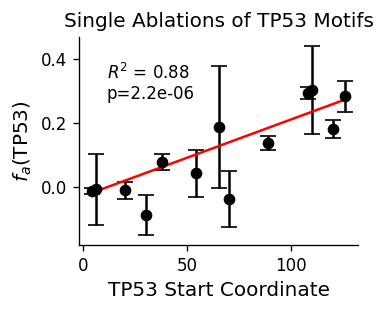

In [83]:
import numpy as np
import statsmodels.api as sm

# get all rows with jaspar_cluster = 50
cur_analysis_df = single_del_df[single_del_df['jaspar_cluster']=='cluster_50'].copy()
# sort by motif_pos
cur_analysis_df.sort_values('motif_pos',inplace=True)
# reset index
cur_analysis_df.reset_index(inplace=True,drop=True)
cur_analysis_df['std_err_h2k'] = cur_analysis_df['std_delta_h2k']/np.sqrt(3)

# plot mean_delta_h2k vs motif_pos
plt.figure(figsize=(3,2.25))
plt.errorbar(cur_analysis_df['motif_pos'],cur_analysis_df['mean_delta_h2k'],yerr=cur_analysis_df['std_err_h2k'],fmt='o',color='k',capsize=5)
plt.xlabel('TP53 Start Coordinate',fontsize=AXIS_FSIZE)
# plt.ylabel('Mean $\Delta$log2(HEPG2/K562)',fontsize=AXIS_FSIZE)
plt.ylabel('$f_a$(TP53)',fontsize=AXIS_FSIZE)
plt.title('Single Ablations of TP53 Motifs')
# despine
sns.despine()

# Calculate weights based on standard errors
w = 1 / cur_analysis_df['std_delta_h2k'].values**2
x = cur_analysis_df['motif_pos'].values.astype(float) # AAAAAHAHHAHAHHHHH why can't np do this automatically
y = cur_analysis_df['mean_delta_h2k'].values

# Add a constant term to the independent variable matrix
X = sm.add_constant(x)

# Fit the weighted linear regression model
model = sm.WLS(y, X, weights=w)  # Note: You can use weights directly or specify them in the `WLS` function
results = model.fit()

# Print the regression results
print(results.summary())

# plot trendline
plt.plot(cur_analysis_df['motif_pos'], results.fittedvalues, 'r', label='fitted line')

# add r_value and p_value to plot
plt.text(0.1,0.7,f'$R^2$ = {results.rsquared:.2f}\np={results.pvalues[1]:.1e}',transform=plt.gca().transAxes,fontsize=TEXT_FSIZE)

# save figure
plt.savefig(f'{figure_dir}/fig4_tp53_single_ablation_vs_pos.png',dpi=600,bbox_inches='tight')